# 1)      Валідація двох альтернатив: additive VS multiplicative;

2)      Описова частина (Moving Average, Exponential Smoothing, Differencing, Stationarity);

3)      Валідація двох альтернатив приведення до стаціонарного ряду: decomposition VS differencing;

4)      Тренування та валідація MA, AR, ARMA, ARIMA моделей;

5)      Генерація фіч та валідація ML моделей (тут на Ваш смак будь-які з відомих регресивних моделей). Буде вважатися плюсом додавання додаткових екзогенних факторів, таких як опади, площі і тп.

6)      Висновки щодо того, яку модель краще використовувати;

7)      Прогноз на наступний рік

8)      На основі одержаного прогнозу планування ресурсів на наступний рік, використовуючи додаткову інформацію:

# Initialise environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import datetime 
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

# reading data from files 

In [2]:
REGION =   ['PRK', 'Perak', 'PRK'] # <==== variant = ...30 % 7 = 2, selecting third region 

In [3]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

In [4]:
production.head()

index Region  Year  Month  Production  Diff_production
0      0     JH  1998      1     118.359            0.000
1      1     JH  1998      2     147.988            0.000
2      2     JH  1998      3     145.514           29.629
3      3     JH  1998      4     154.638           -2.474
4      4     JH  1998      5     155.827            9.124

In [5]:
rainfall.head()

Region  Year  Month    Rainfall
0  Johor  1980      1  254.566667
1  Johor  1981      1   67.500000
2  Johor  1982      1  124.833333
3  Johor  1983      1  149.866667
4  Johor  1984      1  446.900000

In [6]:
area.head()

Area_New  Area_ma  Area_ma_new  Area_npa  Area_rpa Region  Year
0       0.0      0.0     0.000000       0.0       0.0     JH  1974
1      59.0    128.0   128.000000     187.0       0.0     JH  1975
2      59.0    147.0   147.000000     206.0       0.0     JH  1976
3      56.0    171.0   116.538462     227.0       0.0     JH  1977
4      59.0    191.0    93.423077     250.0       0.0     JH  1978

In [7]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [8]:
def process_data(production, rainfall, area, region, PRODUCTION_LAGS, RAINFALL_LAGS):
    data = production[production.Region == region[0]]
    data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                    rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                    on=['Year', 'Month'], how='left')

    data = pd.merge(data, area[area.Region == region[2]][
        ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')

    data['Year'] = data['Year'].astype(int)
    data['Month'] = data['Month'].astype(int)
    data.reset_index(inplace=True)

    data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                   inplace=True)

    data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
    data['Time'] = np.arange(len(data))

    for lag in RAINFALL_LAGS:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
        data['Rainfall_{0}'.format(lag)] = temp

    for lag in PRODUCTION_LAGS:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
        data['Production_{0}'.format(lag)] = temp

    PRODUCTION = data.Production
    data.drop(['Production'], axis=1, inplace=True)

    data.fillna(data.mean(), inplace=True)

    #  And finally drop rainfalls
    data.drop(['Rainfall'], axis=1, inplace=True)
    ### HERE I CAN ADD FEATURE ENGINEERING!!!

    #  And clip first year
    for col in data.columns:
        data['_'.join([region[1], str(col)])] = data[col]
        data.drop([col], axis=1, inplace=True)
        
    return (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])


In [9]:
#Read down variant
DATA = process_data(production, rainfall, area, REGION, PRODUCTION_LAGS, RAINFALL_LAGS)

In [136]:
DATA[0].tail()

Perak_Month  Perak_Area_ma  Perak_Area_npa  Perak_Area_rpa  \
2017-05-01            5     312.421053      349.157895        8.263158   
2017-06-01            6     312.421053      349.157895        8.263158   
2017-07-01            7     312.421053      349.157895        8.263158   
2017-08-01            8     312.421053      349.157895        8.263158   
2017-09-01            9     312.421053      349.157895        8.263158   

            Perak_Area_ma_new  Perak_Time  Perak_Rainfall_6  Perak_Rainfall_7  \
2017-05-01         153.390283         232           249.300           202.200   
2017-06-01         153.390283         233           175.024           249.300   
2017-07-01         153.390283         234           293.520           175.024   
2017-08-01         153.390283         235           230.612           293.520   
2017-09-01         153.390283         236           218.084           230.612   

            Perak_Rainfall_8  Perak_Rainfall_9  Perak_Rainfall_10  \
2017-05-01           206.400           143.640             175.76   
2017-06-01           202.200           206.400             143.64   
2017-07-01           249.300           202.200             206.40   
2017-08-01           175.024           249.300             202.20   
2017-09-01           293.520           175.024             249.30   

            Perak_Rainfall_11  Perak_Rainfall_12  Perak_Production_6  \
2017-05-01             104.30             239.39             132.994   
2017-06-01             175.76             104.30             138.888   
2017-07-01             143.64             175.76             118.818   
2017-08-01             206.40             143.64             138.743   
2017-09-01             202.20             206.40             186.465   

            Perak_Production_7  Perak_Production_8  Perak_Production_9  \
2017-05-01             129.867             147.820             153.346   
2017-06-01             132.994             129.867             147.820   
2017-07-01             138.888             132.994             129.867   
2017-08-01             118.818             138.888             132.994   
2017-09-01             138.743             118.818             138.888   

            Perak_Production_10  Perak_Production_11  Perak_Production_12  
2017-05-01              139.503              141.734              126.876  
2017-06-01              153.346              139.503              141.734  
2017-07-01              147.820              153.346              139.503  
2017-08-01              129.867              147.820              153.346  
2017-09-01              132.994              129.867              147.820

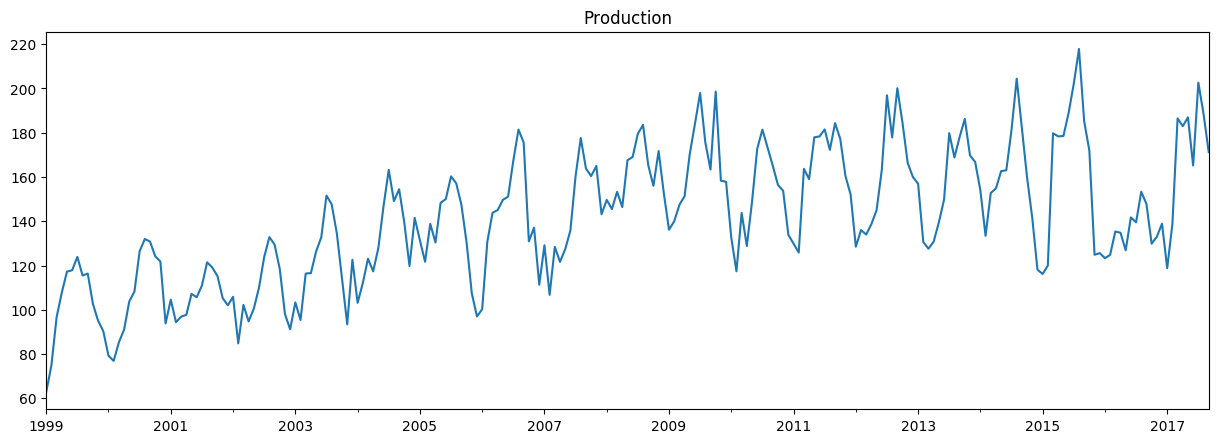

In [11]:
raw_ts = DATA[1]
raw_ts.plot(title = 'Production')

# 1)      Валідація двох альтернатив: additive VS multiplicative;
If the TS has multiplicative nature we can explect the growth in amplitude of values during period (it is explained with propperty that change of magnitude in one variable of product (Seson*Trend*Residuals) will affect resulting data. We can observe it like increase or decrease of seasonal oscilations. 
Therefore check those properties between first and last quarters:

## presume that whe know appropriate seasonality (we know that crop cycle is 1 year)

In [12]:
CYCLE = 12

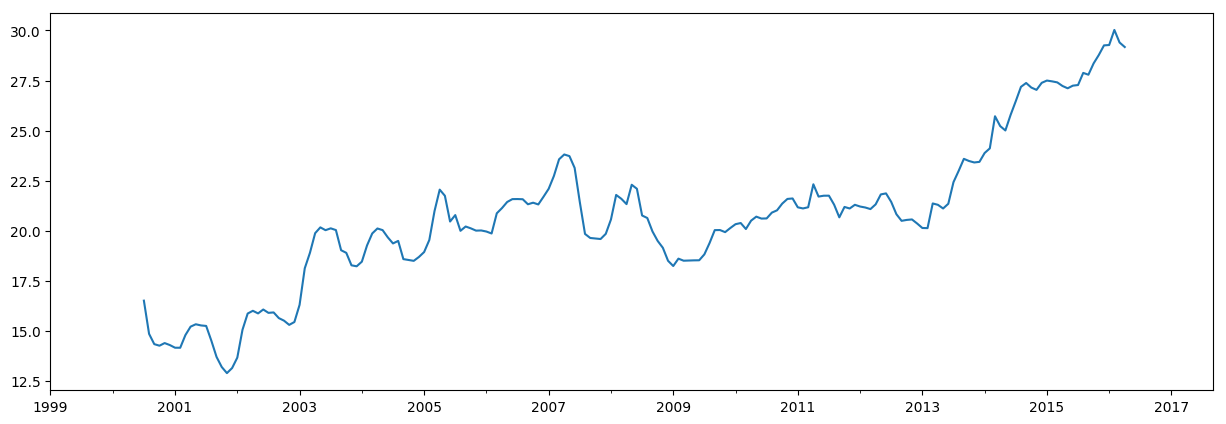

In [13]:
raw_ts.rolling(3*CYCLE, center=True).std().plot()

In [14]:
#can't use pdp on default 
def my_centered_roll (window_size, data, np_function,step):
    spans = []
    side_offset = window_size // 2
    
    start = 0
    end = start + window_size
    while end < len(data):
        piece = data[start:end]
        spans.append(np_function(piece))
        end+=step
        start+=step
    return spans

In [15]:
pdps = my_centered_roll(3*CYCLE, raw_ts, np.ptp, CYCLE)
print(np.mean(pdps))

80.827


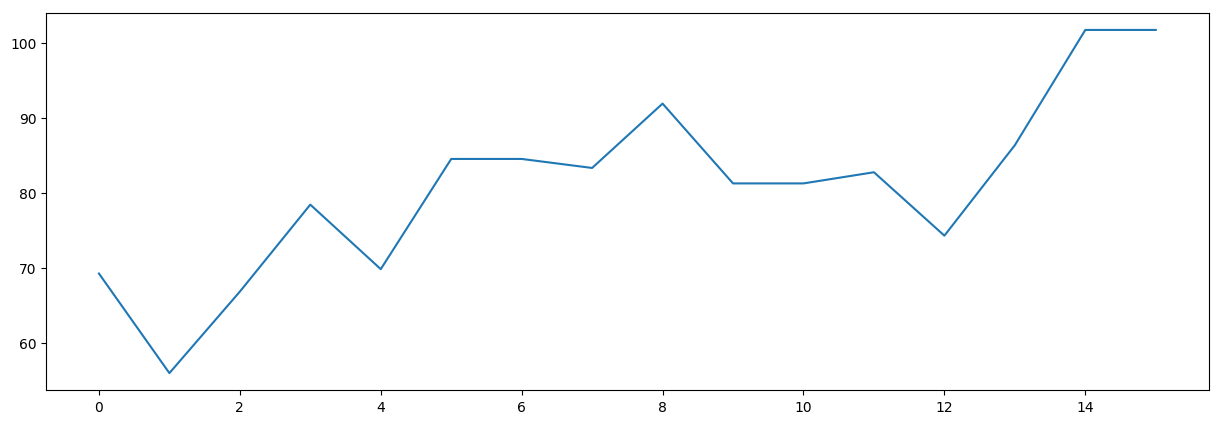

In [16]:
plt.plot(pdps)

As we observe, there is increase in magnitude of data, therefore process migh be multiplicative. 
To avoid possible problems log it's values

In [17]:
ts_log = np.log (raw_ts)

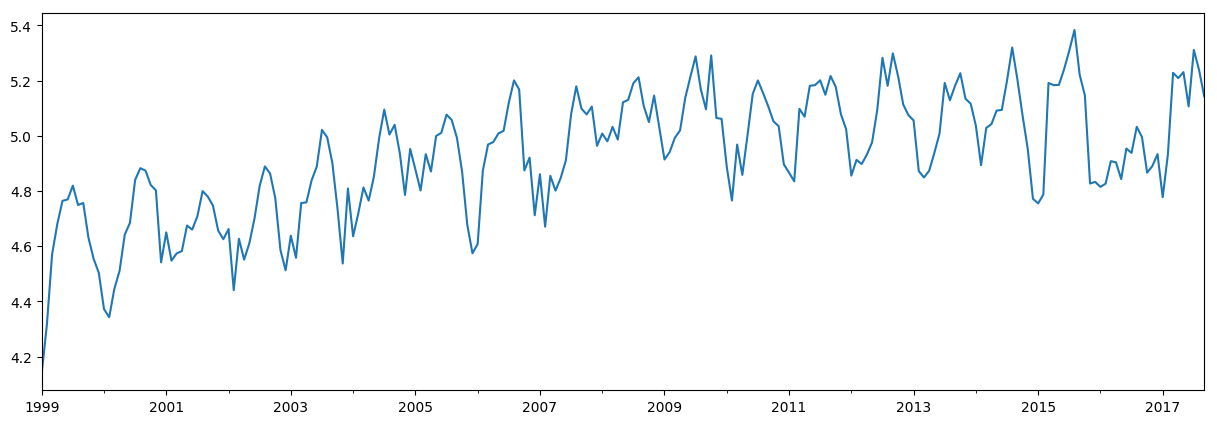

In [18]:
ts_log.plot()

0.588473947374


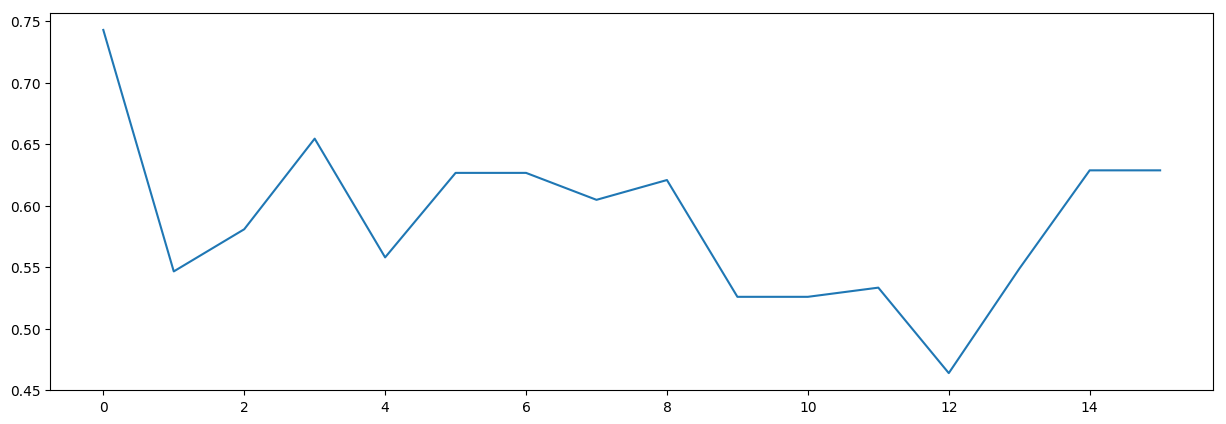

In [19]:
log_pdps = my_centered_roll(3*CYCLE, ts_log, np.ptp, CYCLE)
print(np.mean(log_pdps))
plt.plot(log_pdps)

 ## As we see oscilations amplitude decreased dramatically and become zero-centered, assume hypothesis of multiplicative nature of data confirmed.

# 2) Описова частина (Moving Average, Exponential Smoothing, Differencing, Stationarity);

# Stationarity 
we will use Dickey-Fuller test to determine is there left significant time-dependand part in our data

In [20]:
from statsmodels.tsa.stattools import adfuller
def stationarity_test(ts):
    
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()

    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    # Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(ts, autolag='AIC')
    print(dftest)     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)    
def small_stat_test(ts):
    result = adfuller(ts)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

### As expected we obtain large p-value () , and statistics value significantly larger then critical values for 10%, 5%, 1% probability to reject hypothesis of non-stationarity.

Results of Dickey-Fuller Test:
(-1.7426388634344894, 0.40928826422452763, 12, 212, {'10%': -2.5740891037735847, '1%': -3.4615775784078466, '5%': -2.8752718989837249}, -387.566920415705)
Test Statistic                  -1.742639
p-value                          0.409288
#Lags Used                      12.000000
Number of Observations Used    212.000000
Critical Value (10%)            -2.574089
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
dtype: float64


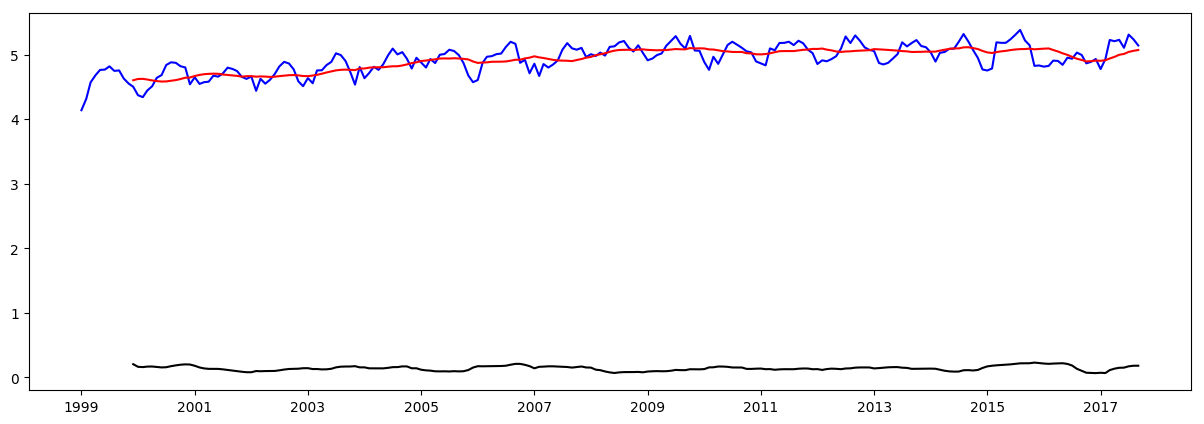

In [21]:
stationarity_test(ts_log)

# Moving avarage analysys
This kind of analysys gives us estimation of general trend over our dataset, as we see, 3 cycles are generally enought for avoding seasonal oscilations

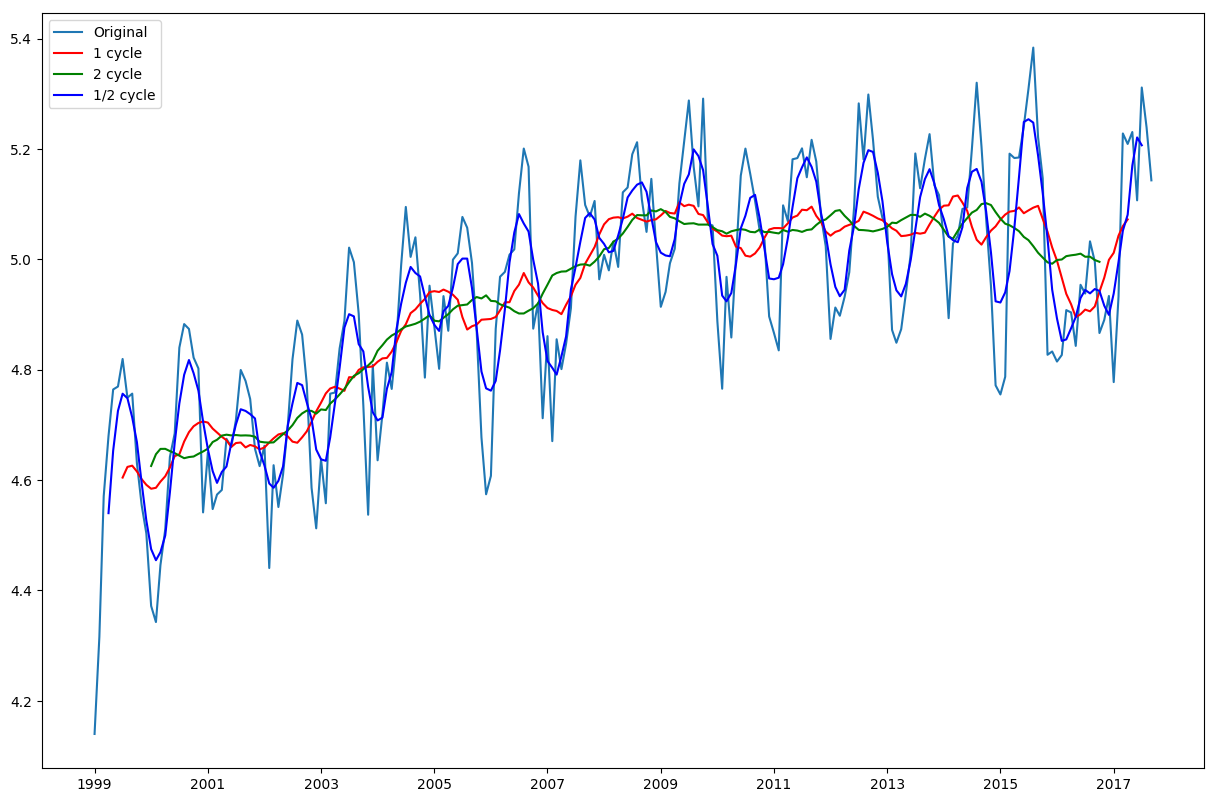

In [22]:
ts_moving_avg_center1 = ts_log.rolling(CYCLE, center=True).mean()
ts_moving_avg_center1.dropna(inplace=True)
# ts_moving_avg_center1.fillna(method='ffill', inplace=True)

ts_moving_avg_center2 = ts_log.rolling(2*CYCLE, center=True).mean()
ts_moving_avg_center2.dropna(inplace=True)
# ts_moving_avg_center2.fillna(method='ffill', inplace=True)


ts_moving_avg_center05 = ts_log.rolling(CYCLE//2, center=True).mean()
ts_moving_avg_center05.dropna(inplace=True)
# ts_moving_avg_center05.fillna(method='ffill', inplace=True)
matplotlib.rcParams['figure.figsize'] = 15, 10
plt_original, = plt.plot(ts_log, )
plt_1cycle, =plt.plot(ts_moving_avg_center1, color='red')
plt_2cycle, =plt.plot(ts_moving_avg_center2, color='green')
plt_0_5cycle, =plt.plot(ts_moving_avg_center05, color='blue')
plt.legend(
    [plt_original, plt_1cycle, plt_2cycle,  plt_0_5cycle],
           ['Original', '1 cycle', '2 cycle', '1/2 cycle']
)
matplotlib.rcParams['figure.figsize'] = 15, 5

## Detrended data (shocks)

In [23]:
print(ts_log.mean())
print ("Original Mean=[{}]   STD= [{}]  PTP = [{}] ".format(
    (ts_log  ).mean(),
    (ts_log  ).std(),
    (ts_log  ).ptp()
)) 
log_dif_cycle1 = ts_log - ts_moving_avg_center1
log_dif_cycle1.dropna(inplace= True)
print ("1 cycle Mean=[{}]   STD= [{}]   PTP = [{}]".format(  
    log_dif_cycle1.mean(),
    log_dif_cycle1.std(),
    log_dif_cycle1.ptp())
)
log_dif_cycle2 = ts_log - ts_moving_avg_center2
log_dif_cycle2.dropna(inplace= True)
print ("2 cycle Mean=[{}]   STD= [{}]   PTP = [{}]".format( 
    log_dif_cycle2.mean(),
    log_dif_cycle2.std(),
    log_dif_cycle2.ptp())
)

log_dif_cycle05 = ts_log - ts_moving_avg_center05
log_dif_cycle05.dropna(inplace= True)
print ("1/2 cycle Mean=[{}]   STD= [{}]   PTP = [{}]".format( # < === severe lost of variance
    log_dif_cycle05.mean(),
    log_dif_cycle05.std(),
    log_dif_cycle05.ptp())
)


4.92600557495
Original Mean=[4.926005574952578]   STD= [0.22294049966092713]  PTP = [1.2440068973621905] 
1 cycle Mean=[0.0006300926280265633]   STD= [0.13497912126105852]   PTP = [0.6072318423428156]
2 cycle Mean=[-0.0019250163443965938]   STD= [0.14432846314152925]   PTP = [0.7203854100132201]
1/2 cycle Mean=[0.002574145739884076]   STD= [0.08100984017748851]   PTP = [0.44434233684697233]


## clearify what type of MA trend is the best with test

In [24]:
small_stat_test(log_dif_cycle1)
small_stat_test(log_dif_cycle2)
small_stat_test(log_dif_cycle05)

ADF Statistic: -6.852219
p-value: 0.000000
Critical Values:
	10%: -2.574
	1%: -3.463
	5%: -2.876
ADF Statistic: -6.426772
p-value: 0.000000
Critical Values:
	10%: -2.575
	1%: -3.466
	5%: -2.877
ADF Statistic: -6.866767
p-value: 0.000000
Critical Values:
	10%: -2.574
	1%: -3.462
	5%: -2.876


##  As 1/2 cycle MA allso gets away part of seasonality,  we see that best detrending occures when we are taking 1-cycled intervals in consiveration

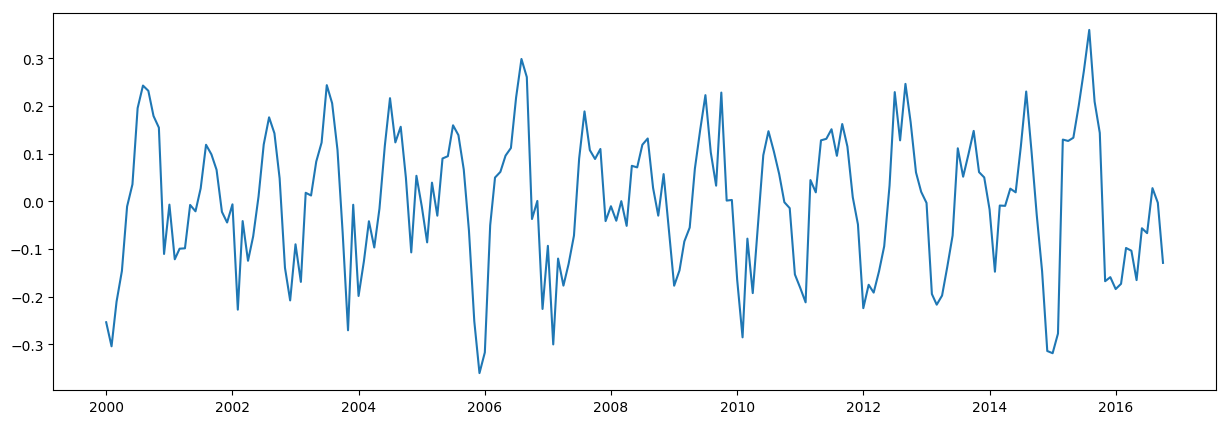

In [25]:
ts_detrended_MA = ts_log - ts_moving_avg_center2
plt.plot(ts_detrended_MA)

### As we observe that best centered result were obtained with approximation equalt to 1 Cycle, we can assume that our hypothesis about cycle length is valid.

# Exponential Smoothing
### This analysys type used for approximations of ts, reconstruction and short-term predictions of TS, main feature is that we use 'weighed' sum of a series episodes, usually giving more weight to closer episodes then to decent ones (in real TS close episodes have bigger autocorrelation). Allso it is good because we preserve all data period (tail and head of TS)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(adjust=True,halflife=12,min_periods=0,ignore_na=False).mean()
  if __name__ == '__main__':


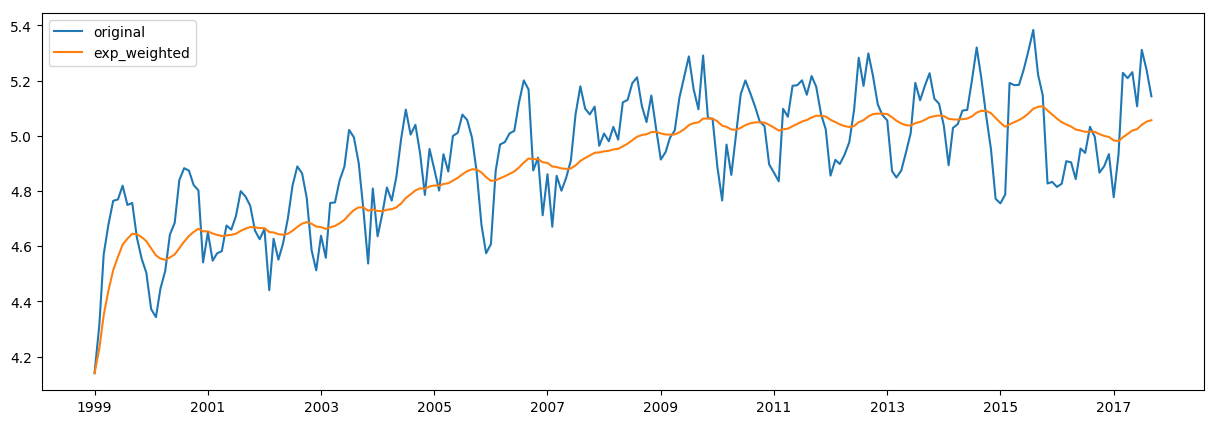

In [26]:
expwighted_avg = pd.ewma(ts_log, halflife=CYCLE)
orig, = plt.plot (ts_log)
exp_w, = plt.plot(expwighted_avg)
plt.legend(
    [orig, exp_w],
    ['original', 'exp_weighted']
)

0.037611011276
0.143858616472
0.613764737559


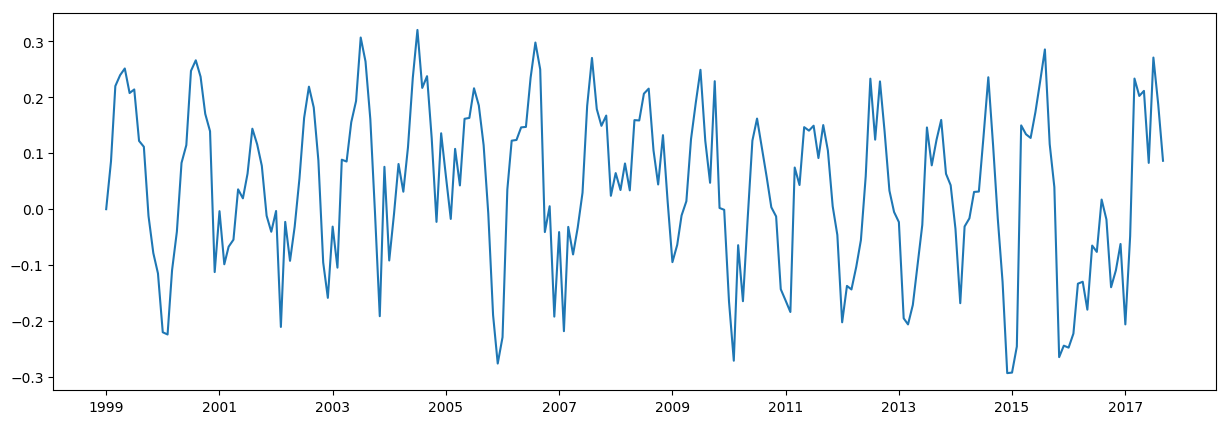

In [27]:
exp_detrended = ts_log - expwighted_avg
plt.plot(exp_detrended)
print (np.mean(exp_detrended))
print (np.std(exp_detrended) )
print (np.ptp(exp_detrended) )

Results of Dickey-Fuller Test:
(-3.7770398252581145, 0.0031511596057393989, 12, 212, {'10%': -2.5740891037735847, '1%': -3.4615775784078466, '5%': -2.8752718989837249}, -412.06599241678782)
Test Statistic                  -3.777040
p-value                          0.003151
#Lags Used                      12.000000
Number of Observations Used    212.000000
Critical Value (10%)            -2.574089
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
dtype: float64


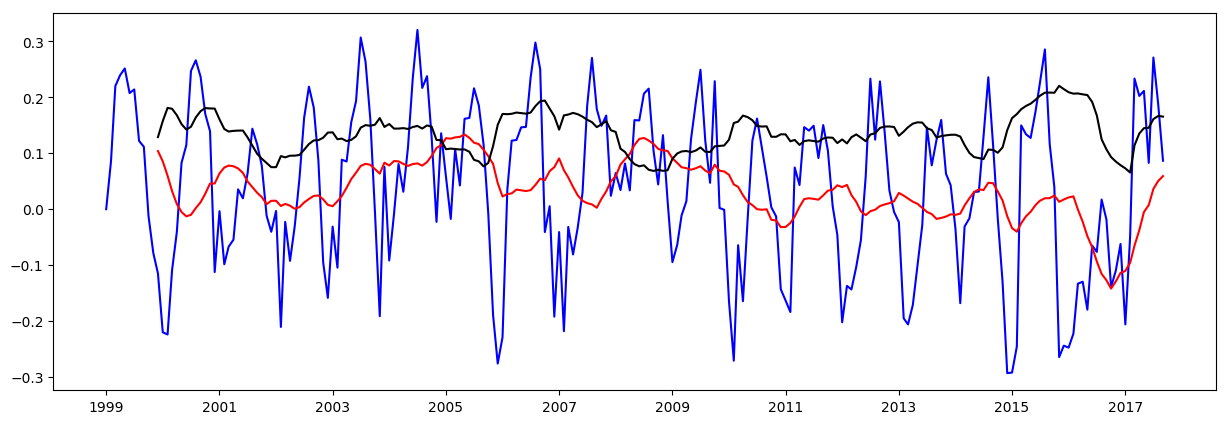

In [28]:
stationarity_test(exp_detrended)

# Differencing
We can apply this method to state what parameter d we have to use as ARIMA parameter to obtain stationarity of a model

Results of Dickey-Fuller Test:
(-3.2490579806455981, 0.017314925017764125, 14, 198, {'10%': -2.574611347821651, '1%': -3.4638151713286316, '5%': -2.8762506321350432}, -345.67651395796202)
Test Statistic                  -3.249058
p-value                          0.017315
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (10%)            -2.574611
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
dtype: float64


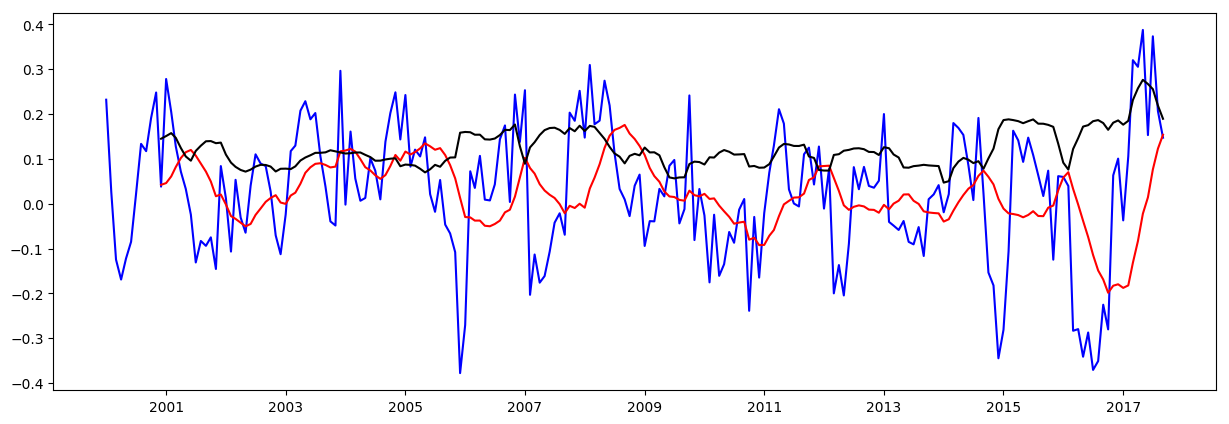

In [29]:
ts_log_dif1 = ts_log.diff(periods=CYCLE)
ts_log_dif1.dropna(inplace=True)
stationarity_test(ts_log_dif1)

Results of Dickey-Fuller Test:
(-3.9286458582717283, 0.0018338569817866242, 13, 187, {'10%': -2.5750770662586864, '1%': -3.465811691080702, '5%': -2.8771233514726489}, -197.00233985666569)
Test Statistic                  -3.928646
p-value                          0.001834
#Lags Used                      13.000000
Number of Observations Used    187.000000
Critical Value (10%)            -2.575077
Critical Value (1%)             -3.465812
Critical Value (5%)             -2.877123
dtype: float64


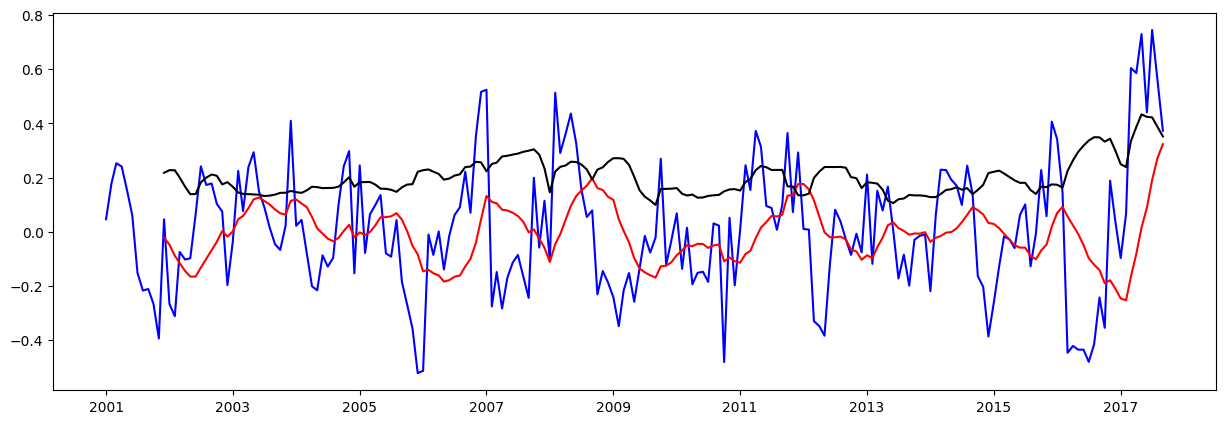

In [30]:
ts_log_dif2 = ts_log_dif1.diff(periods=CYCLE)
ts_log_dif2.dropna(inplace=True)
stationarity_test(ts_log_dif2)

## As we see above, differencing three times exhibits increase of statistics, contrary to expectations. Therefore valid parameter d for ARIMA is 1 or 2. It is not obvious that 2 is worthy, because we do not observe any quadratic trend, moreover, first difference test statistics allready has value allmost critical for 1%, therefore we will assume that d-value = 1 is the best choice.

# 3) Валідація двох альтернатив приведення до стаціонарного ряду: decomposition VS differencing;
### As we've allready performed differencing analysys, here just add decomposition example and check result with tests

In [31]:
# TF decompose
from statsmodels.tsa.seasonal import seasonal_decompose

def _decompose(ts, freq):
    decomposition = seasonal_decompose(ts, freq=freq, model='additive')

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    return residual, trend, seasonal

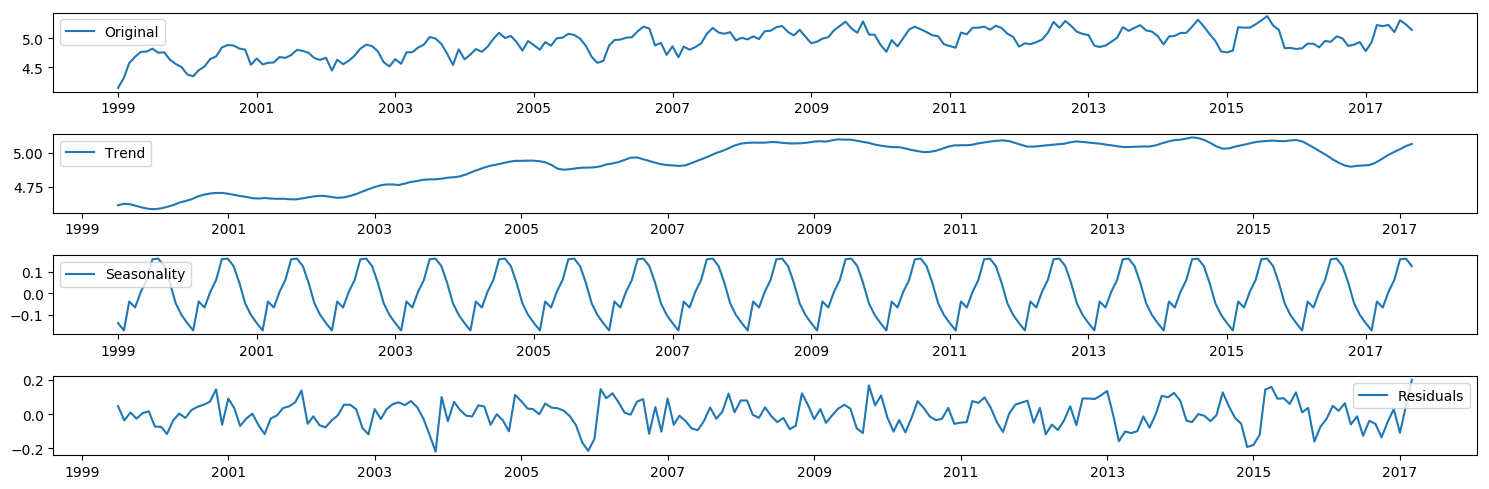

In [32]:
ts_log_decomposed_residuals, ts_log_decomposed_trend, ts_log_decomposed_seasonal = _decompose(ts_log, CYCLE)
ts_log_decomposed_residuals.dropna(inplace=True)
ts_log_decomposed_trend.dropna(inplace=True)
ts_log_decomposed_seasonal.dropna(inplace=True)

Results of Dickey-Fuller Test:
(-7.4968166257863569, 4.3576031558712498e-11, 14, 198, {'10%': -2.574611347821651, '1%': -3.4638151713286316, '5%': -2.8762506321350432}, -491.58145510189593)
Test Statistic                -7.496817e+00
p-value                        4.357603e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (10%)          -2.574611e+00
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
dtype: float64


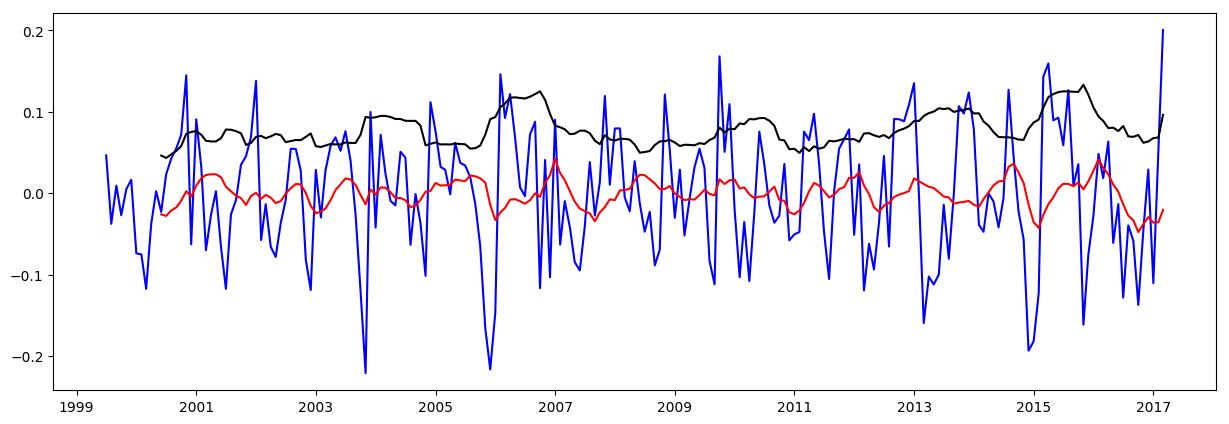

In [33]:
stationarity_test(ts_log_decomposed_residuals)

 Mean=[-0.0010961630752086386]   STD= [0.07851163040376279]   PTP = [0.42153262431904953]  <=== decomposed residuals

 Mean=[0.026363952679468432]   STD= [0.14629374204037815]   PTP = [0.7657282446613358] < === original dif-1 residuals 


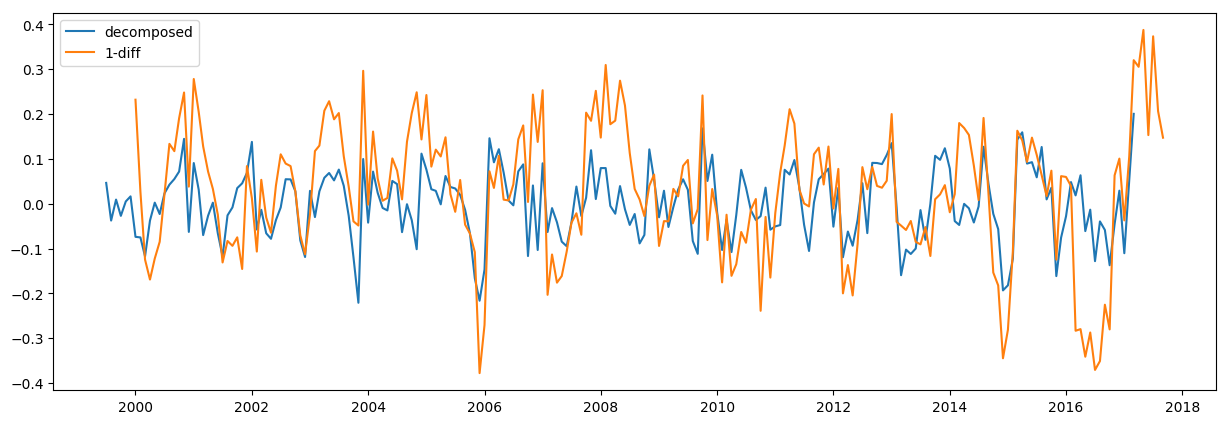

In [34]:
dec, = plt.plot(ts_log_decomposed_residuals)
dif1, = plt.plot(ts_log_dif1)
plt.legend([dec,dif1],['decomposed', '1-diff'])
print (" Mean=[{}]   STD= [{}]   PTP = [{}]  <=== decomposed residuals".format( 
    ts_log_decomposed_residuals.mean(),
   ts_log_decomposed_residuals.std(),
    ts_log_decomposed_residuals.ptp())
)
print ()
print (" Mean=[{}]   STD= [{}]   PTP = [{}] < === original dif-1 residuals ".format( 
    ts_log_dif1.mean(),
   ts_log_dif1.std(),
    ts_log_dif1.ptp())
)

### Here we obtained two really similar representation. But we are not sure if seasonality preserved in dif1 unlike in case of decomposed data. Allso due to mean smoothing we've lost some info from dif1. But nevertheless there are more data episodes preserved and similarity is obvious. Therefore leave both examples for a farther tests.

# 4) Тренування та валідація MA, AR, ARMA, ARIMA моделей;

In [35]:
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARIMAResults, ARMAResults
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

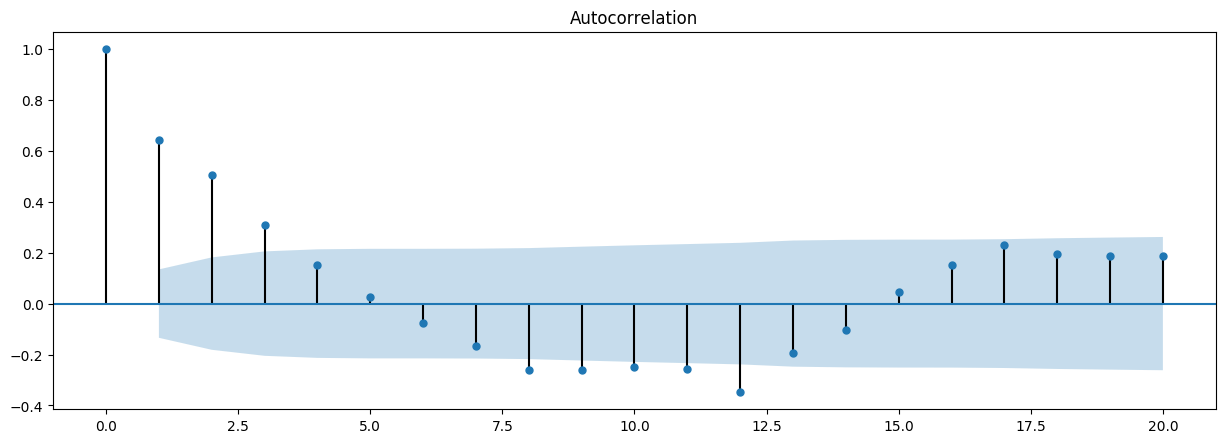

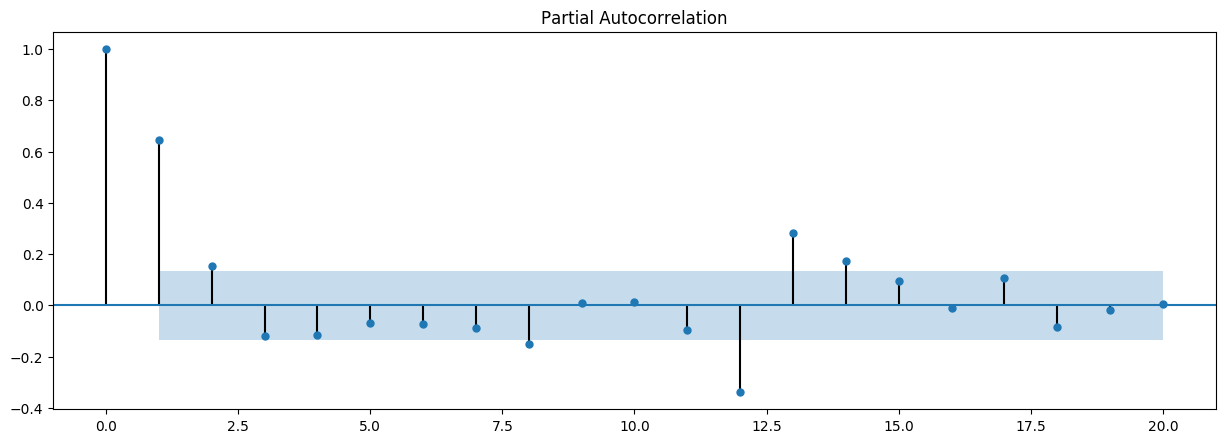

In [36]:
plot_acf(ts_log_dif1, lags = 20 )
plot_pacf(ts_log_dif1, lags = 20, method='ols')
plt.show()

# P = 3-4, Q = 2

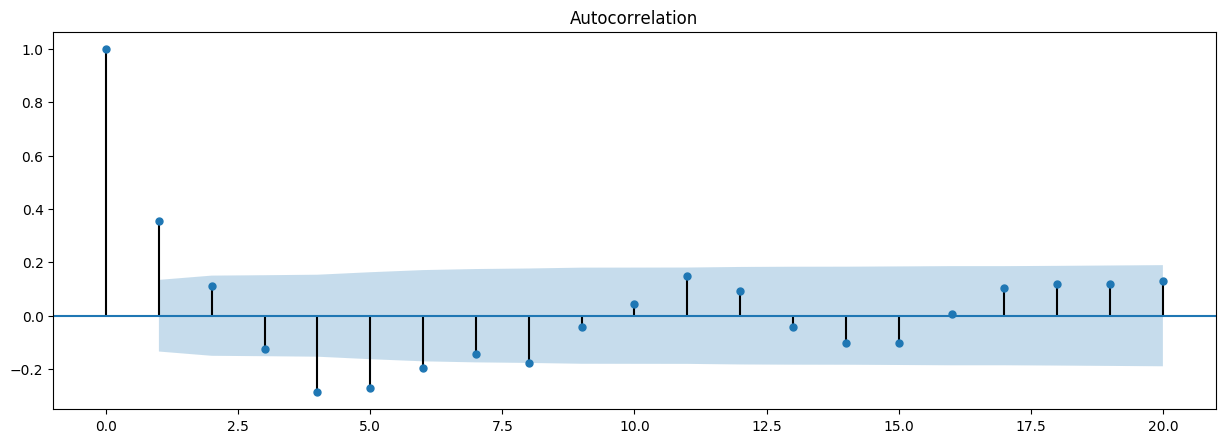

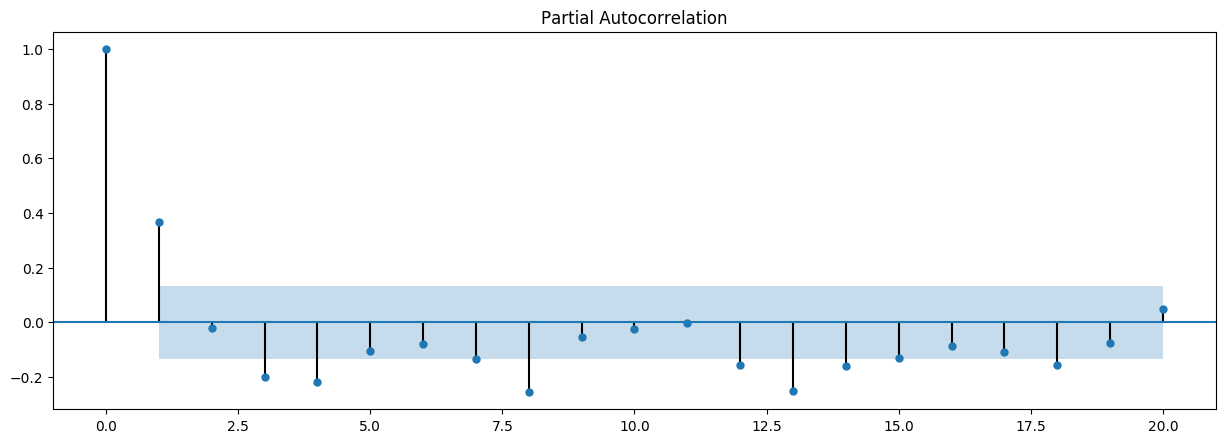

In [37]:
plot_acf(ts_log_decomposed_residuals, lags = 20 )
plot_pacf(ts_log_decomposed_residuals, lags = 20, method='ols')
plt.show()

## for decomposed residuals Q and P candidate values are 2 and 2.

In [38]:
def RMSE(data, fitted_model):
    dif_row = fitted_model.fittedvalues-data
    dif_row.dropna(inplace = True)
    return np.sqrt(sum((dif_row)**2))
def fit_and_plot_ARIMA(data, order):
    model = ARIMA (data, order = order )
    fitted_model = model.fit(disp=-1)
    plt.plot(data)
    plt.plot(fitted_model.fittedvalues.shift(-2*order[1]), color='red')
    plt.title('RMSE: %.4f'% RMSE(data,fitted_model ) )

# MA

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


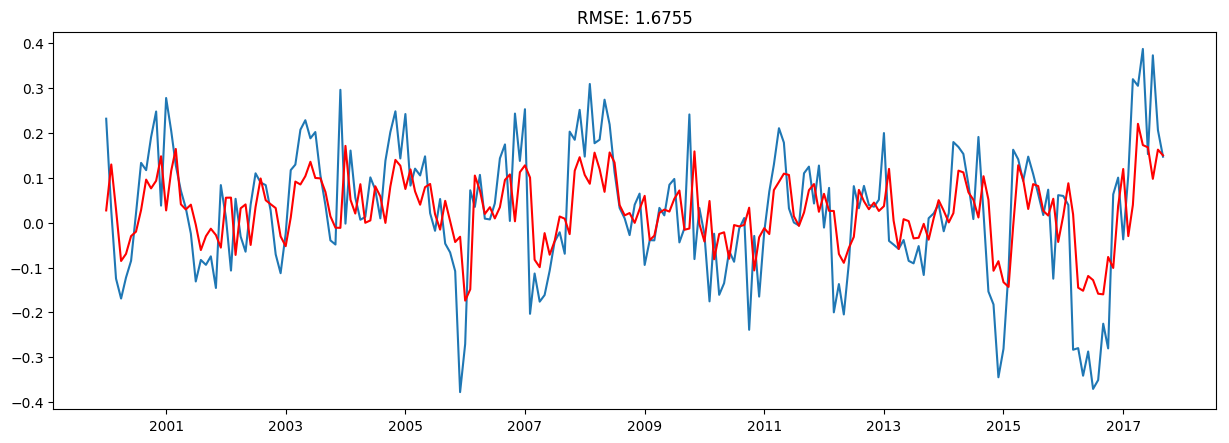

In [39]:
fit_and_plot_ARIMA(ts_log_dif1, (0,0,2))

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


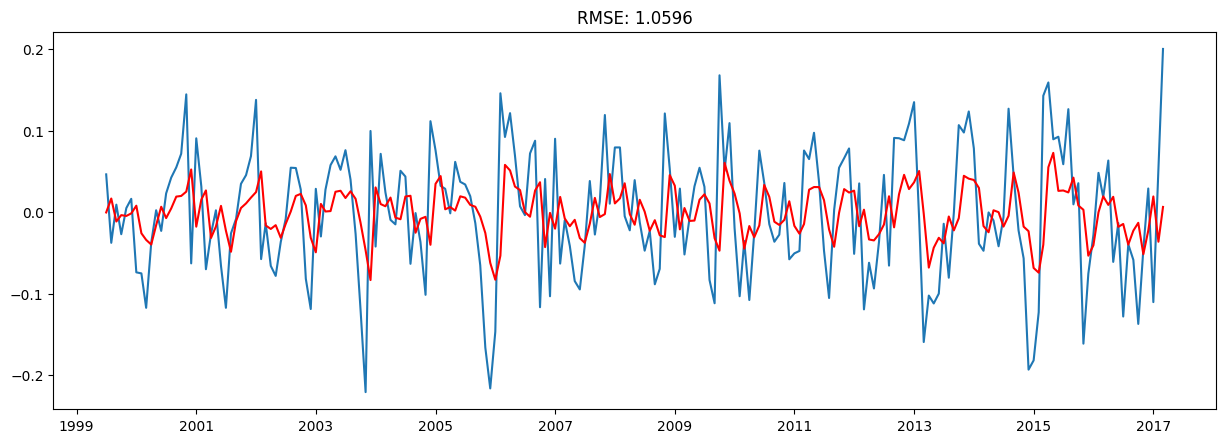

In [40]:
fit_and_plot_ARIMA(ts_log_decomposed_residuals, (0,0,2))

# AR

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


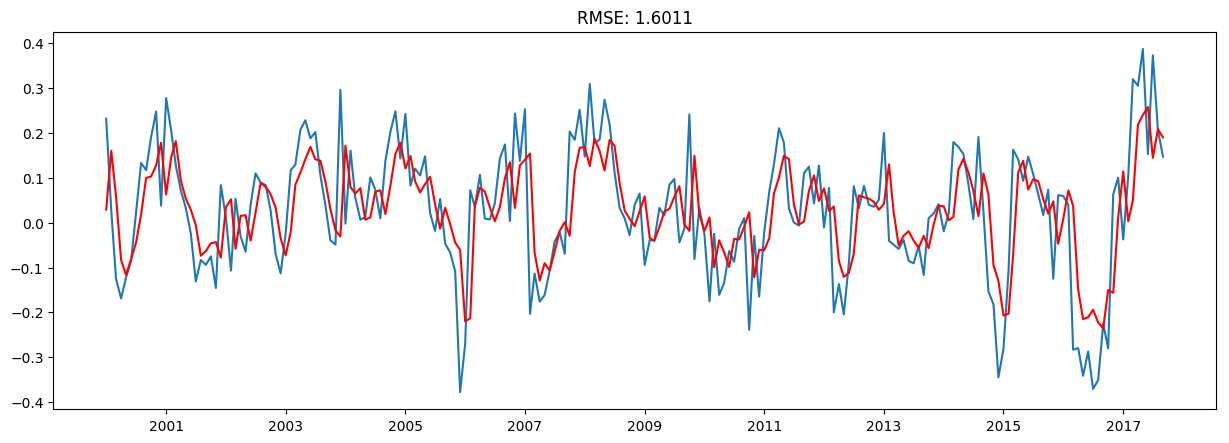

In [41]:
fit_and_plot_ARIMA(ts_log_dif1, (3,0,0))

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


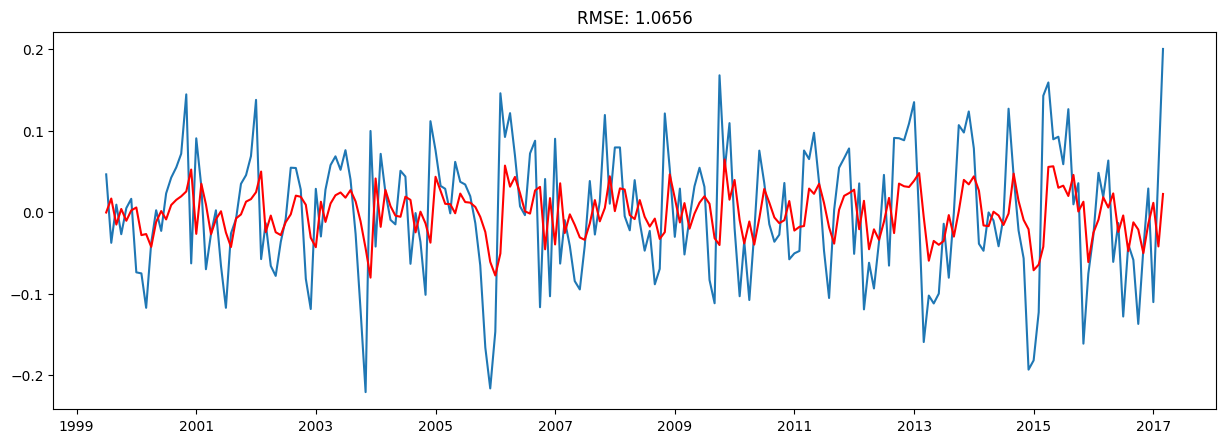

In [42]:
fit_and_plot_ARIMA(ts_log_decomposed_residuals, (2,0,0))

# ARMA

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


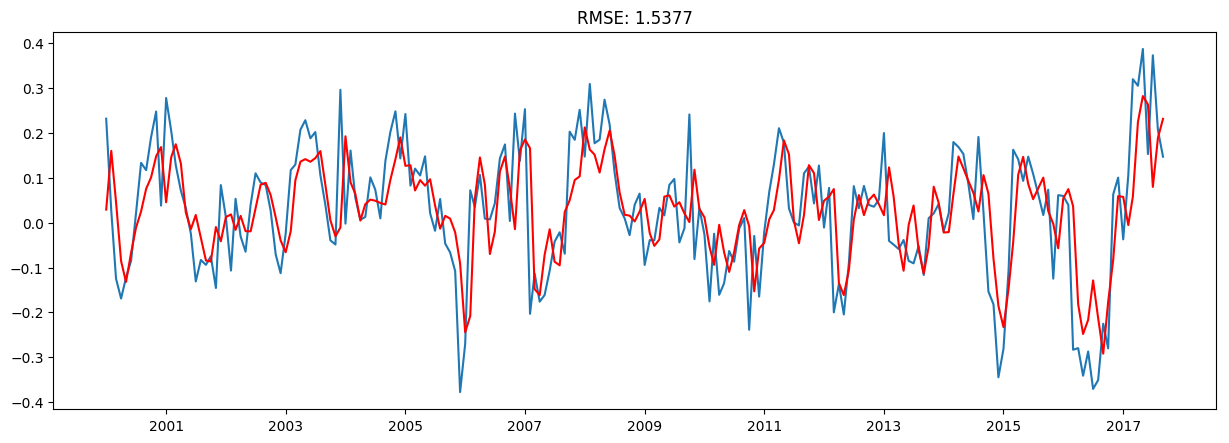

In [43]:
fit_and_plot_ARIMA(ts_log_dif1, (3,0,2))

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


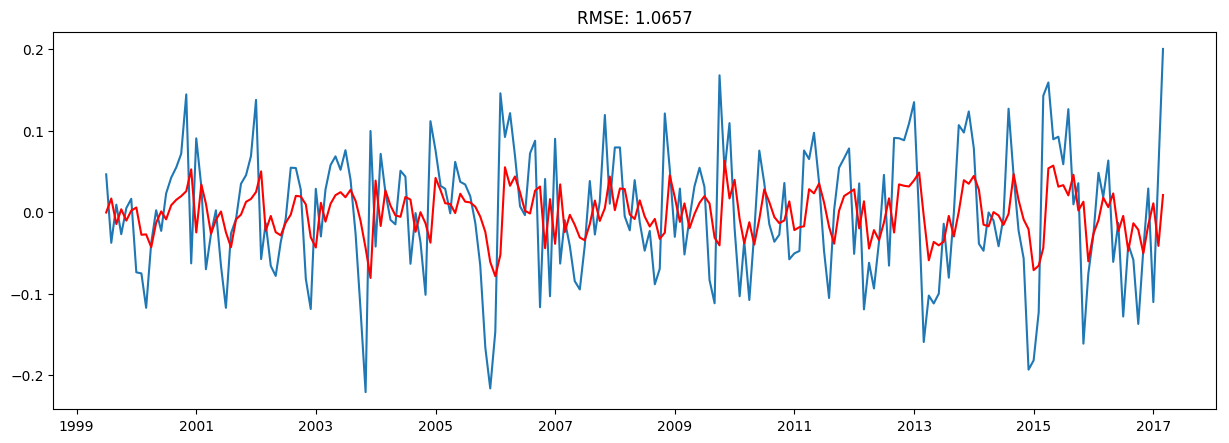

In [44]:
fit_and_plot_ARIMA(ts_log_decomposed_residuals, (1,0,1))

# 5) Генерація фіч та валідація ML моделей (тут на Ваш смак будь-які з відомих регресивних моделей). Буде вважатися плюсом додавання додаткових екзогенних факторів, таких як опади, площі і тп.

In [45]:
ts_log_decomposed_residuals.tail()

2016-11-01   -0.045501
2016-12-01    0.029016
2017-01-01   -0.110529
2017-02-01    0.054647
2017-03-01    0.200441
Name: Production, dtype: float64

In [46]:
training_border = "2016-10-01" #year from data_end

#### failed to find ready-to-use methods, written tools:

In [47]:
def decompose_train_valid(ts, timestamp):
    ts_train = ts[ts.index < timestamp]
    ts_valid = ts[ts.index >= timestamp]
    return ts_train, ts_valid

In [48]:
def invert_diff_periods (diff, first_period):
    """first_period
    [diff] Series (obtained as a result of <series_object>.diff(periods=k))
    [first_period] Series - original k-first beggining before .diff(k) occured  
    """
    diff.dropna(inplace = True)
    refined = first_period.append (diff)
    period_len = len (first_period)
    for i in range(len(refined) - period_len):
        refined[i+period_len] += refined[i]
    return refined

In [49]:
def my_MSE(a,b):
    dif = (a - b).dropna()
    MSE = np.sqrt(np.sum((a - b).dropna() ** 2))
    return MSE

In [50]:
def split_lats_year(training_data):
    training_border = training_data.index[-12]
    print ("Data span from: [{}]  to: [{}]".format(training_data.index[0], training_data.index[-1]))
    print ("Split_border [{}]  ".format(training_border))
    train, valid = decompose_train_valid(training_data, timestamp=training_border)
    return train, valid

In [51]:
from scipy.stats import norm
#TODO make real feat with gaussian
def plot_errors(model_errors):
    mean = np.mean(model_errors)
    std = np.std(model_errors)
    print ("Mean = [{}] STD = [{}]".format(mean, std))
    x_axis = np.arange(-3* std, 3 * std, 0.001)
    plt.figure()
    present, = plt.plot(x_axis, norm.pdf(x_axis,mean,std) * 500)
    ideal, = plt.plot(x_axis, norm.pdf(x_axis,0,std) *  500)
    n, bins, patches = plt.hist(model_errors, 50, facecolor='g', alpha=0.24)
    plt.legend([present, ideal], ['current errors','ideal random errors'])
    plt.grid(True)
    plt.show()

# MODEL ON DECOMPOSED RESIDUALS

In [52]:
train, valid = split_lats_year(ts_log_decomposed_residuals)

Data span from: [1999-07-01 00:00:00]  to: [2017-03-01 00:00:00]
Split_border [2016-04-01 00:00:00]  


In [53]:
model = ARIMA(train, order=(3, 0, 2))
model_fit = model.fit() 

print (model_fit.aic)
model_fit.summary().tables[1]

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


-537.1763551766351


<class 'statsmodels.iolib.table.SimpleTable'>

In [54]:
print(model_fit.summary().tables[1])

                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0002    8.2e-05      2.796      0.006    6.86e-05       0.000
ar.L1.Production     1.9518      0.115     16.982      0.000       1.727       2.177
ar.L2.Production    -1.2871      0.184     -6.994      0.000      -1.648      -0.926
ar.L3.Production     0.2336      0.100      2.330      0.021       0.037       0.430
ma.L1.Production    -1.8989      0.092    -20.547      0.000      -2.080      -1.718
ma.L2.Production     0.8989      0.092      9.775      0.000       0.719       1.079


In [55]:
model_fit.aic

-537.1763551766351

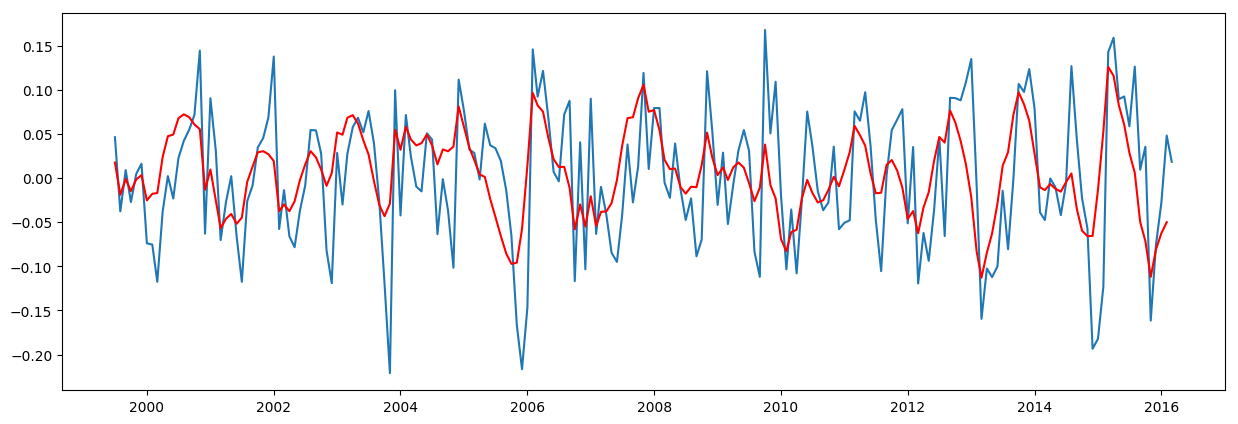

MSE : [0.8668563299339649]


In [56]:
train_forecast = model_fit.fittedvalues
plt.plot(train)
plt.plot(train_forecast.shift(-1), color='red')
plt.show()

print("MSE : [{}]".format(my_MSE(train, train_forecast)) )

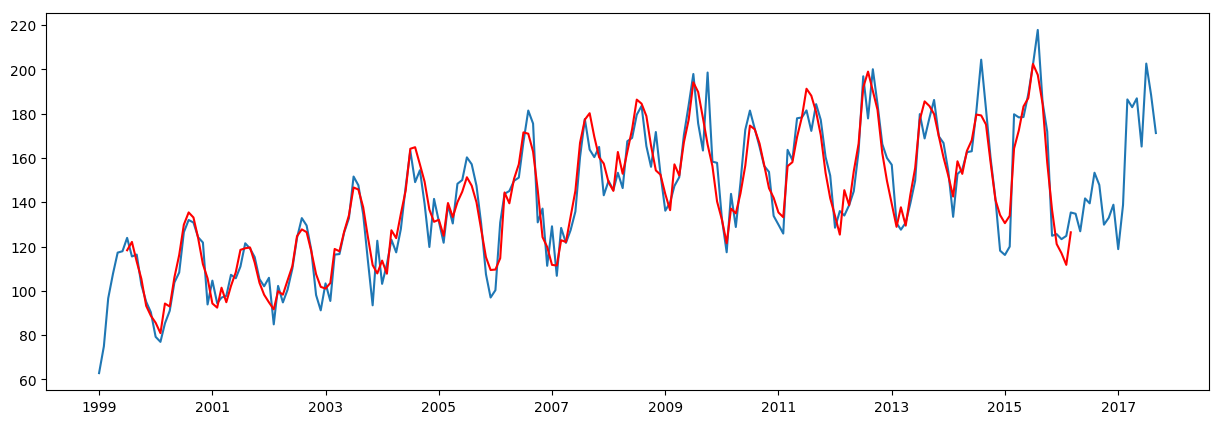

MSE : [121.67281834987345]


In [57]:
train_precition = train_forecast.add(ts_log_decomposed_trend).add(ts_log_decomposed_seasonal).dropna()

restored_data = np.exp(ts_log)
restored_prediction = np.exp(train_precition)

plt.plot(restored_data)
plt.plot(restored_prediction, color="red")
plt.show()
print("MSE : [{}]".format(my_MSE(restored_data, restored_prediction)) )

Mean = [-0.34758635689422496] STD = [8.57509718954133]


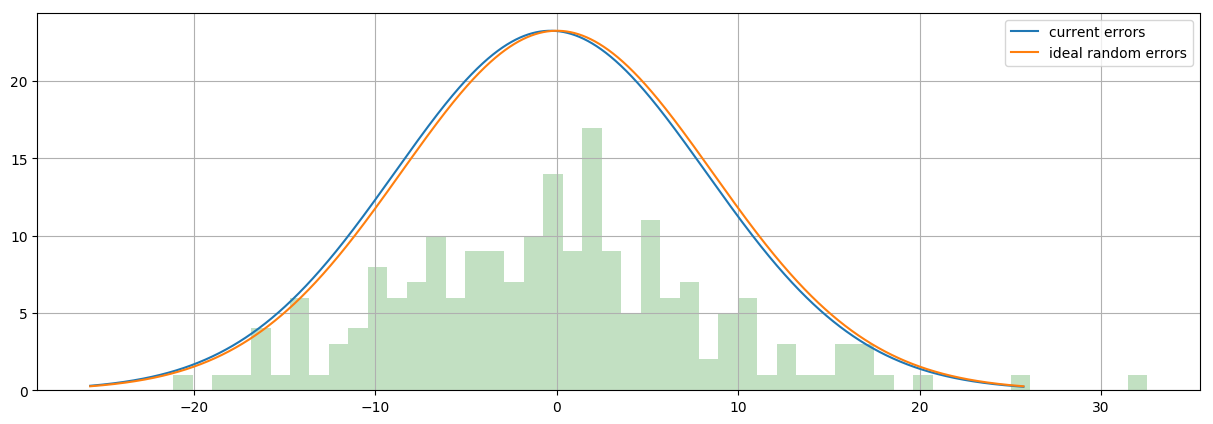

In [58]:
plot_errors( (restored_data - restored_prediction ).dropna() )

In [59]:
validation_forecast = model_fit.forecast(12)[0]
validation_forecast = pd.Series(index=valid.index, data=validation_forecast)
# validation_forecast

In [60]:
combined_data_forecast = train_forecast.append(validation_forecast)

In [61]:
combined_prediction = combined_data_forecast\
                        .add(ts_log_decomposed_trend)\
                        .add(ts_log_decomposed_seasonal)\
                        .dropna()

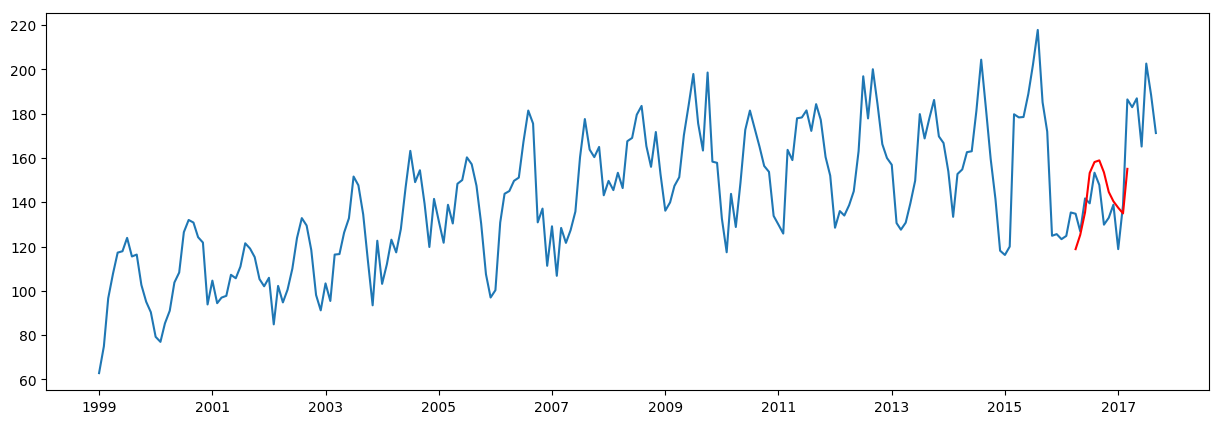

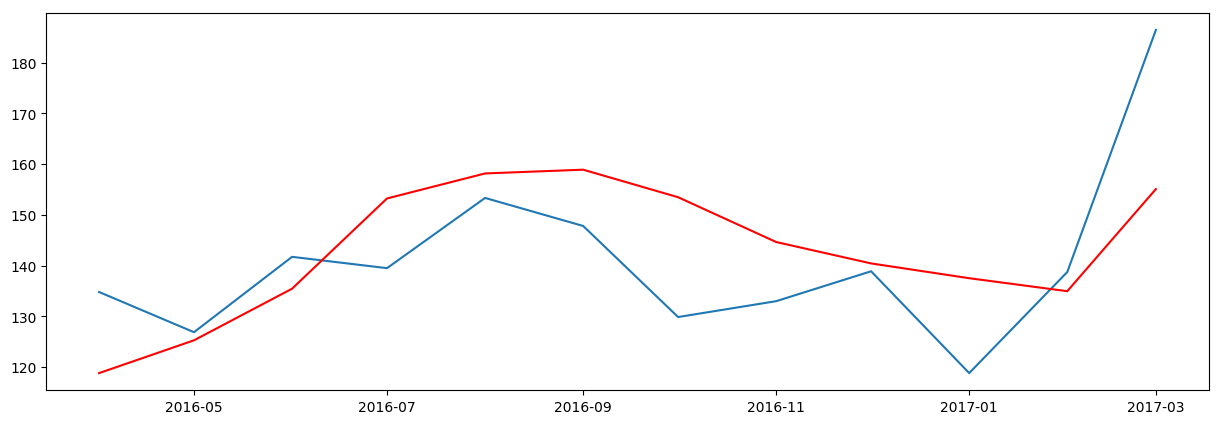

MSE : [51.74508771202301]


In [62]:
restored_forecast = np.exp(combined_prediction)
restored_train = np.exp(ts_log)

plt.plot(restored_train)
plt.plot(restored_forecast[-len(validation_forecast):], color='red')
plt.show()
forcast_frame = restored_forecast.index[-len(validation_forecast):]
plt.plot(restored_train[forcast_frame])
plt.plot(restored_forecast[forcast_frame], color='red')
plt.show()
print("MSE : [{}]".format(my_MSE( restored_train[forcast_frame], restored_forecast[forcast_frame] ) ) )

Mean = [-0.4508131266406485] STD = [9.048263992009915]


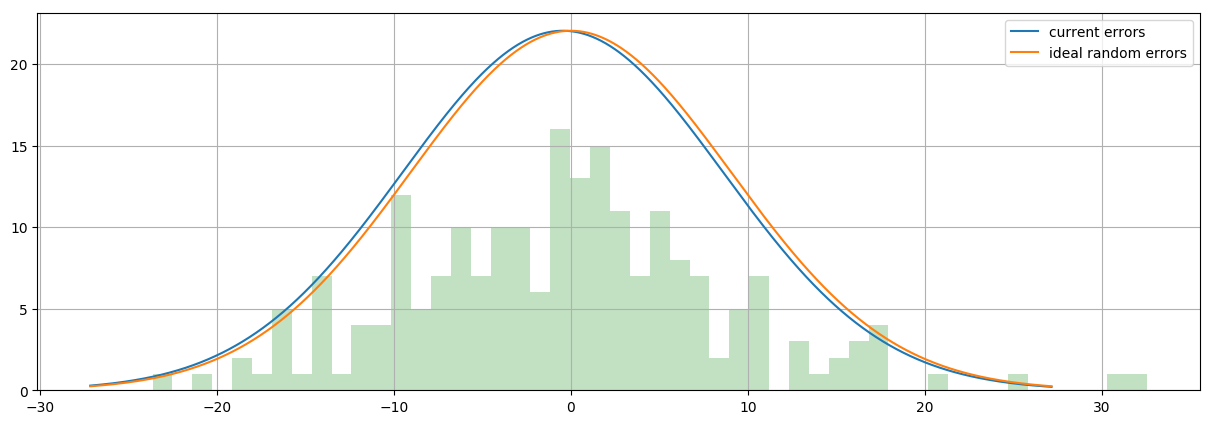

Mean = [-2.1798615198932425] STD = [14.77760847637967]


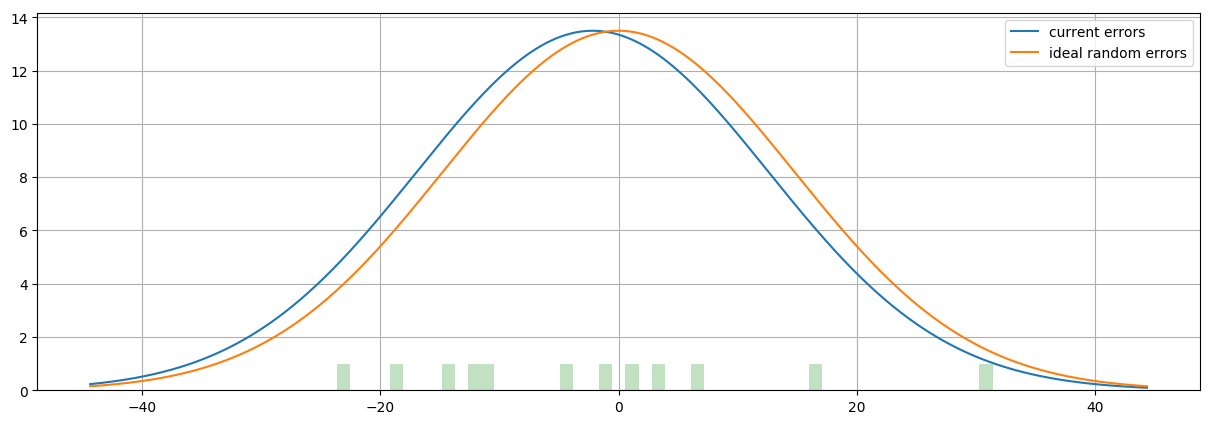

In [63]:
whole_model_errors = (restored_train - restored_forecast).dropna() 
plot_errors(whole_model_errors)
predict_model_error = (restored_train[forcast_frame] -  restored_forecast[forcast_frame]).dropna() 
plot_errors(predict_model_error)


#       Model on Differences

In [64]:
train, valid = split_lats_year(ts_log_dif1)

Data span from: [2000-01-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2016-10-01 00:00:00]  


In [65]:
model = ARIMA(train, order=(3, 0, 2))
model_fit = model.fit() 

print (model_fit.aic)
model_fit.summary().tables[1]

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


-320.4177692307062


<class 'statsmodels.iolib.table.SimpleTable'>

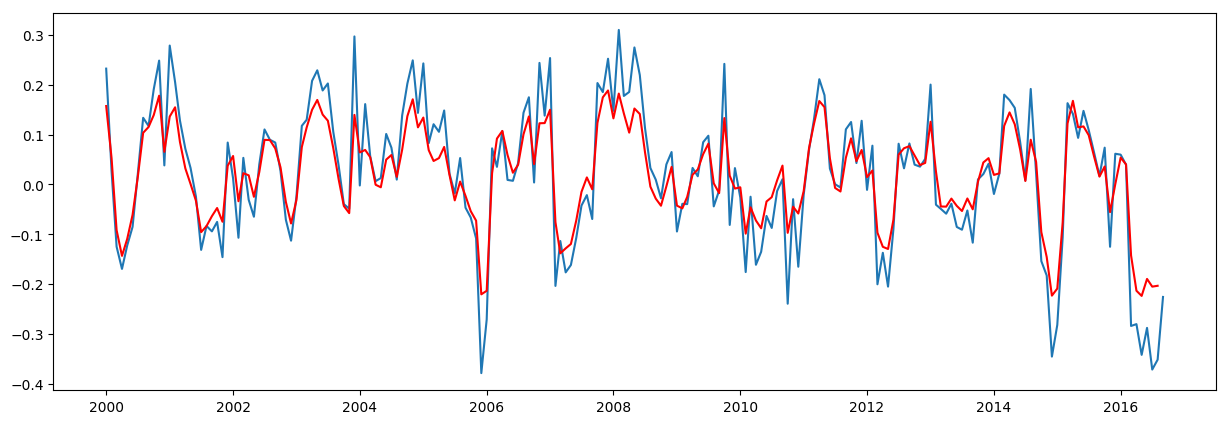

MSE : [1.4977473573028772]


In [66]:
forecast = model_fit.fittedvalues
plt.plot(train)
plt.plot(forecast.shift(-1), color='red')
plt.show()

print("MSE : [{}]".format(my_MSE(train, forecast)) )

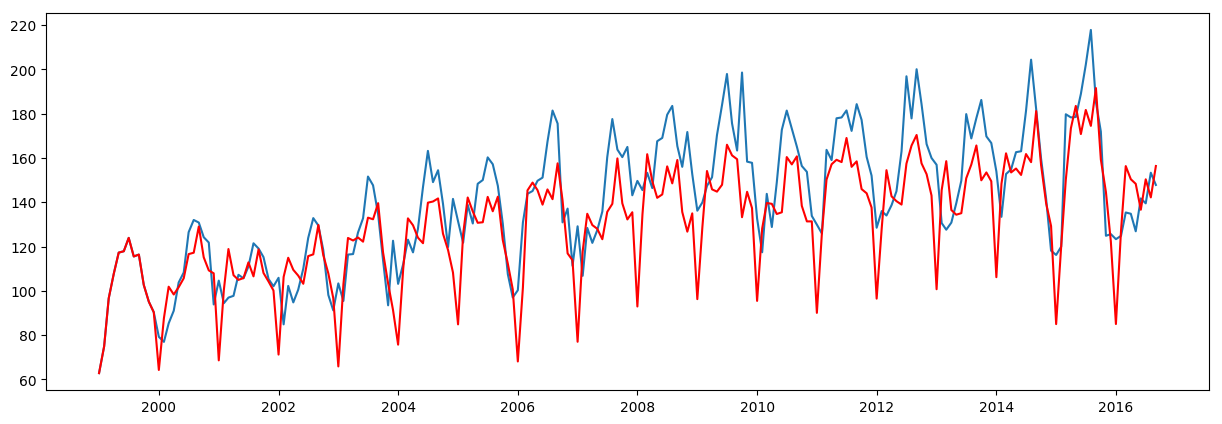

MSE : [291.44742478940003]


In [67]:
train_forecast = model_fit.fittedvalues
restored_forecast = np.exp(invert_diff_periods(train_forecast, ts_log[:CYCLE]))
restored_train = np.exp(invert_diff_periods(train, ts_log[:CYCLE])) 
plt.plot(restored_train)
plt.plot(restored_forecast, color='red')
plt.show()
print("MSE : [{}]".format(my_MSE(restored_train, restored_forecast)) )

In [68]:
validation_forecast = model_fit.forecast(12)[0]
validation_forecast = pd.Series(index=valid.index, data=validation_forecast)
# validation_forecast

In [69]:
combined_data_forecast = train_forecast.append(validation_forecast)
combined_data = train.append(valid)

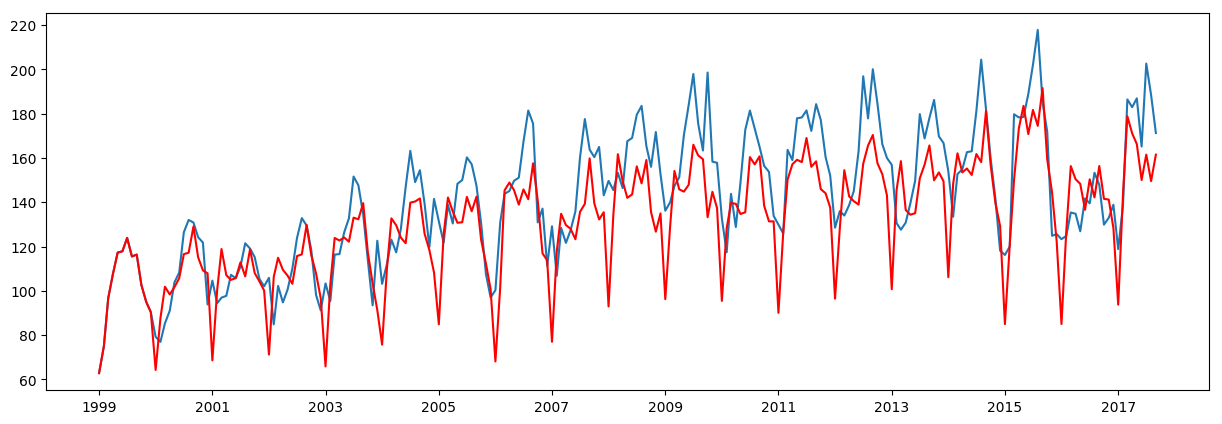

MSE : [300.1252259569195]


In [70]:
restored_forecast = np.exp(invert_diff_periods(combined_data_forecast, ts_log[:CYCLE]))
restored_train = np.exp(invert_diff_periods(combined_data, ts_log[:CYCLE])) 
plt.plot(restored_train)
plt.plot(restored_forecast, color='red')
plt.show()
print("MSE : [{}]".format(my_MSE(restored_train, restored_forecast)) )

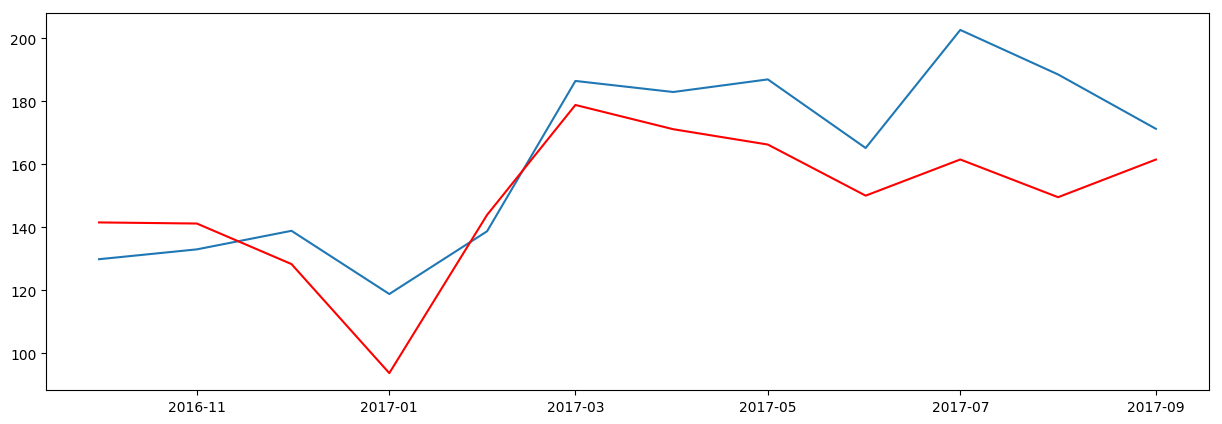

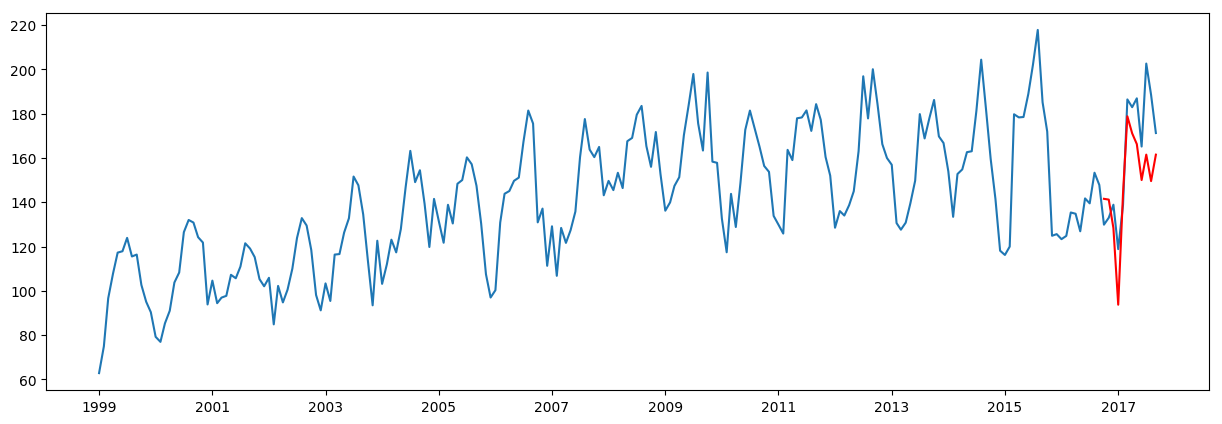

MSE : [71.64879510025997]


In [71]:
restored_forecast = np.exp(invert_diff_periods(combined_data_forecast, ts_log[:CYCLE]))
restored_train = np.exp(invert_diff_periods(combined_data, ts_log[:CYCLE])) 
plt.plot(restored_train[-len(valid):])
plt.plot(restored_forecast[-len(valid):], color='red')
plt.show()
plt.plot(restored_train)
plt.plot(restored_forecast[-len(valid):], color='red')
plt.show()
print("MSE : [{}]".format(my_MSE(restored_train[-len(valid):], restored_forecast[-len(valid):])) )

Mean = [6.3515511208616715] STD = [0.0]


ValueError: max must be larger than min in range parameter.

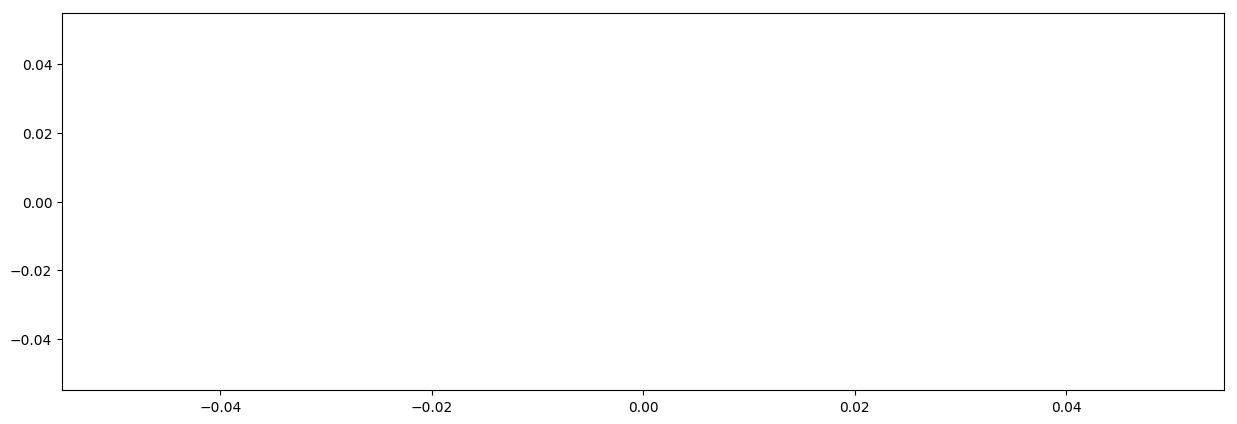

In [178]:
plot_errors(restored_train[-len(valid):] - restored_forecast[-len(valid):] )
plot_errors ( (restored_train - restored_forecast ).dropna() )

## Iterative approach predictor 

In [73]:
history = list(train.copy())
iterative_validation_forecast = list()
for t in range(len(valid)):
    model = ARIMA(history, order=(3,0,2))
    model_fit = model.fit(disp=1)
    output = model_fit.forecast()
    yhat = output[0]
    iterative_validation_forecast.append(yhat)
    obs = valid[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=-0.118147, expected=-0.280484
predicted=-0.124388, expected=0.063207
predicted=0.058552, expected=0.100582
predicted=0.162714, expected=-0.037246
predicted=0.062737, expected=0.105911
predicted=0.090856, expected=0.320187
predicted=0.236179, expected=0.305405
predicted=0.264167, expected=0.387674
predicted=0.293478, expected=0.153053
predicted=0.154436, expected=0.373449
predicted=0.188052, expected=0.206534
predicted=0.237695, expected=0.147252


In [74]:
iterative_validation_forecast = pd.Series(index=valid.index, data=iterative_validation_forecast[0])
combined_data_forecast_with_iterative = train_forecast.append(iterative_validation_forecast)

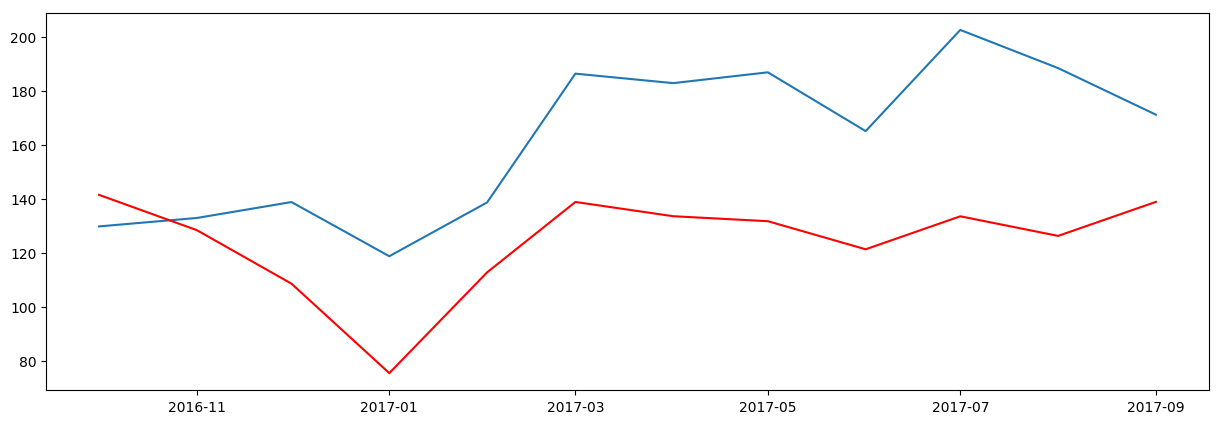

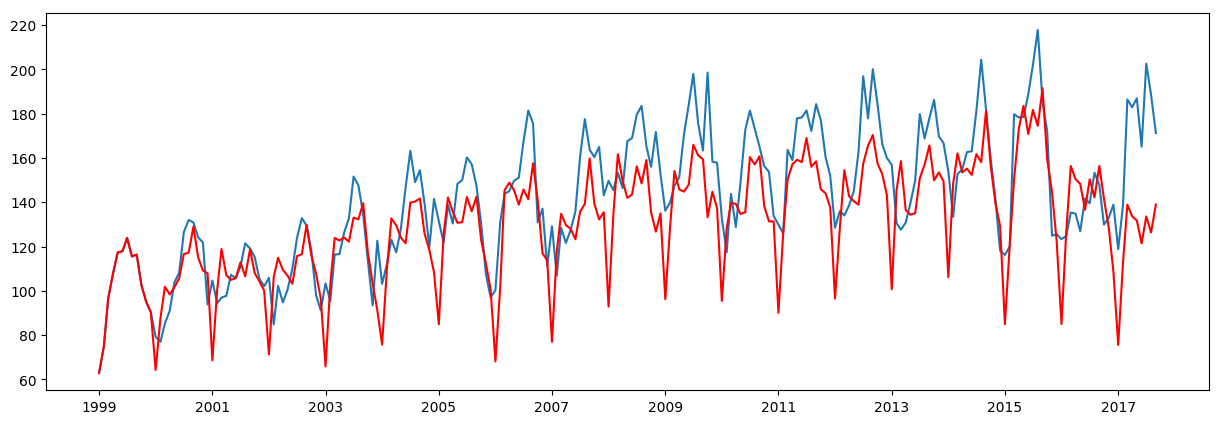

MSE : [151.48909917278223]


In [75]:
restored_forecast = np.exp(invert_diff_periods(combined_data_forecast_with_iterative, ts_log[:CYCLE]))
restored_train = np.exp(invert_diff_periods(combined_data, ts_log[:CYCLE])) 
plt.plot(restored_train[-len(valid):])
plt.plot(restored_forecast[-len(valid):], color='red')
plt.show()
plt.plot(restored_train)
plt.plot(restored_forecast, color='red')
plt.show()
print("MSE : [{}]".format(my_MSE(restored_train[-len(valid):], restored_forecast[-len(valid):])) )

# 6) Висновки щодо того, яку модель краще використовувати;



 # 7) Прогноз на наступний рік

In [76]:
from copy import copy

In [77]:
def generate_prediction_index(available_training_data, raw_data):
    final = raw_data.index[-1] + datetime.timedelta(365.5)
    start = available_training_data.index[-1] #+ datetime.timedelta(30)
    index = list()
    while start < final:
        index.append(copy(copy(start)) )
        start = start + datetime.timedelta(30.5)
    print ("Providing [{}] timestamps from [{}] to [{}]".format(len(index),index[0],index[-1]))
    return index

## Iterative  model on differences

In [78]:
history = list(train.append(valid).copy()) # <=== change is just here
iterative_future_prediction = list()
for t in range(len(valid)):
    model = ARIMA(history, order=(3,0,2))
    model_fit = model.fit(disp=1)
    output = model_fit.forecast()
    yhat = output[0]
    iterative_future_prediction.append(yhat)
    obs = valid[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=0.152821, expected=-0.280484
predicted=-0.174714, expected=0.063207
predicted=-0.090449, expected=0.100582
predicted=0.036594, expected=-0.037246
predicted=-0.019726, expected=0.105911
predicted=0.033907, expected=0.320187
predicted=0.181039, expected=0.305405
predicted=0.226258, expected=0.387674
predicted=0.268951, expected=0.153053
predicted=0.140598, expected=0.373449
predicted=0.198612, expected=0.206534
predicted=0.148628, expected=0.147252


In [79]:
prediction_index = generate_prediction_index (available_training_data=valid, raw_data=raw_ts)

Providing [12] timestamps from [2017-09-01 00:00:00] to [2018-08-02 12:00:00]


In [80]:
iterative_validation_forecast = pd.Series( index=prediction_index,
                                          data=iterative_future_prediction[0] )

fut = combined_data_forecast_with_iterative.append(iterative_validation_forecast)

In [81]:
prediction_period = len(prediction_index)

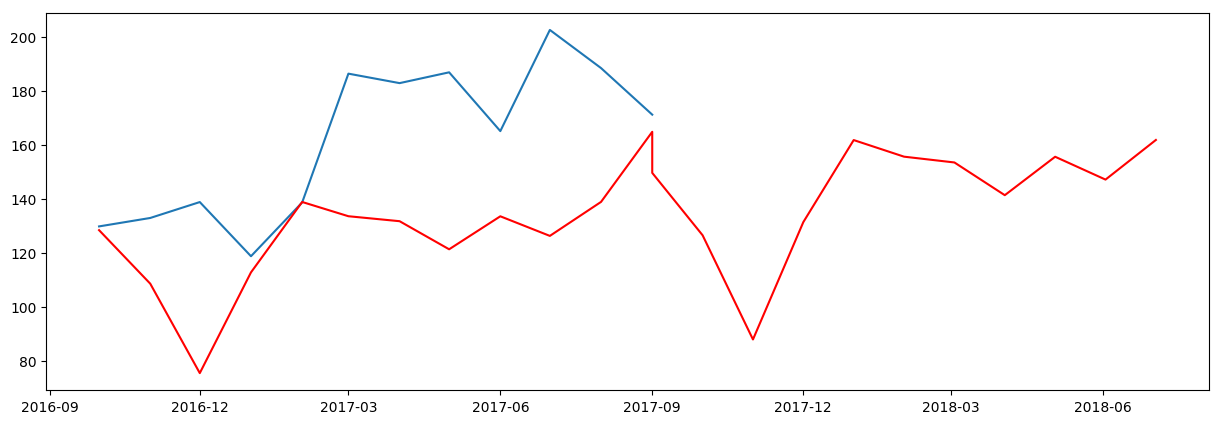

MSE : [151.6221928670799]


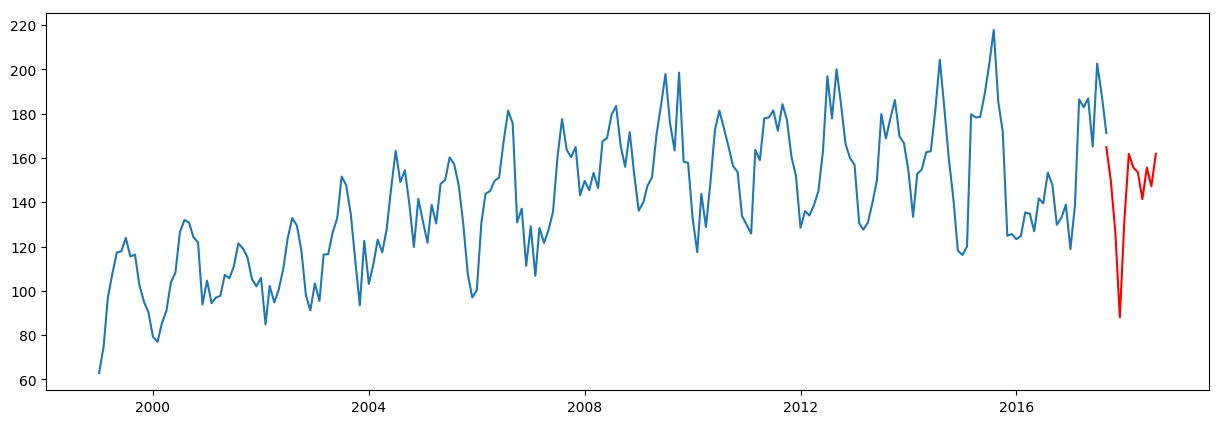

MSE : [328.52837135656176]


In [82]:
restored_forecast = np.exp(invert_diff_periods(fut, ts_log[:CYCLE]))
restored_train = np.exp(invert_diff_periods(combined_data, ts_log[:CYCLE])) 

plt.plot(restored_train[-prediction_period:])
plt.plot(restored_forecast[-2*prediction_period:].shift(-1), color='red')
plt.show()
print("MSE : [{}]".format(my_MSE(restored_train[-prediction_period:], 
                                 restored_forecast[-2*prediction_period:] )) )
plt.plot(restored_train)
plt.plot(restored_forecast[-prediction_period:], color='red')
plt.show()
print("MSE : [{}]".format(my_MSE(restored_train, restored_forecast )) )

# Model on decompositions

## here we actually have to make predictions on three different models: 
 ### one for trend - by some kind of regression.
 ### second for seasonality (it is stationar, so we can just repeat it)
 ### and full scale model for residuals

In [83]:
train, valid = split_lats_year(ts_log_decomposed_seasonal)

Data span from: [1999-01-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2016-10-01 00:00:00]  


In [84]:
prediction = pd.Series(index = valid.index, data=train.data[-len(valid):] )

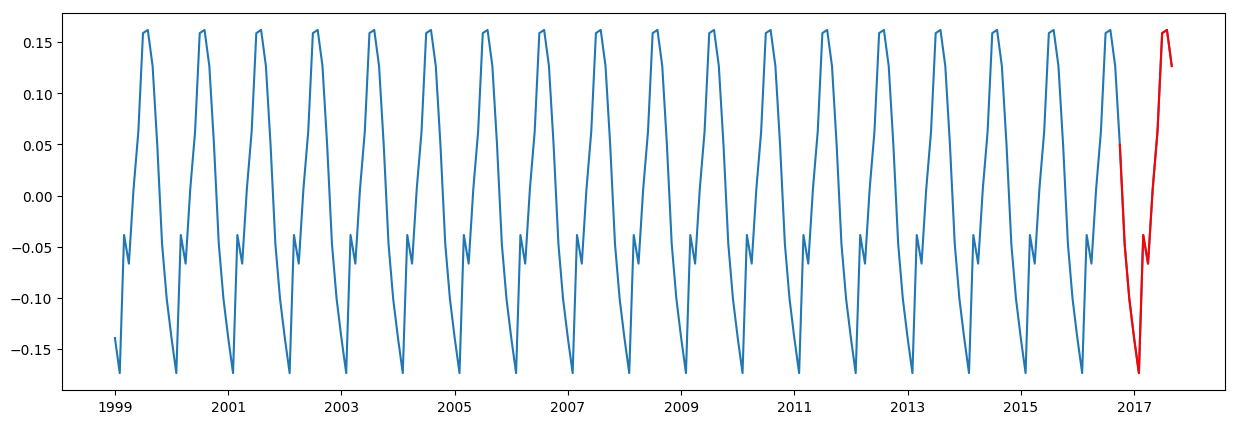

MSE : [0.0]


In [85]:

plt.plot(train.append(valid))
plt.plot(prediction, color='red')
plt.show()
print("MSE : [{}]".format(my_MSE(valid, prediction )) ) # <=== we've done all good

In [86]:
# now similar prediciton for the future

In [87]:
prediction_index = generate_prediction_index (available_training_data=ts_log_decomposed_seasonal, raw_data=raw_ts)

Providing [12] timestamps from [2017-09-01 00:00:00] to [2018-08-02 12:00:00]


In [88]:
future_seasons = pd.Series(index = prediction_index, data=train.data[-len(prediction_index):] )

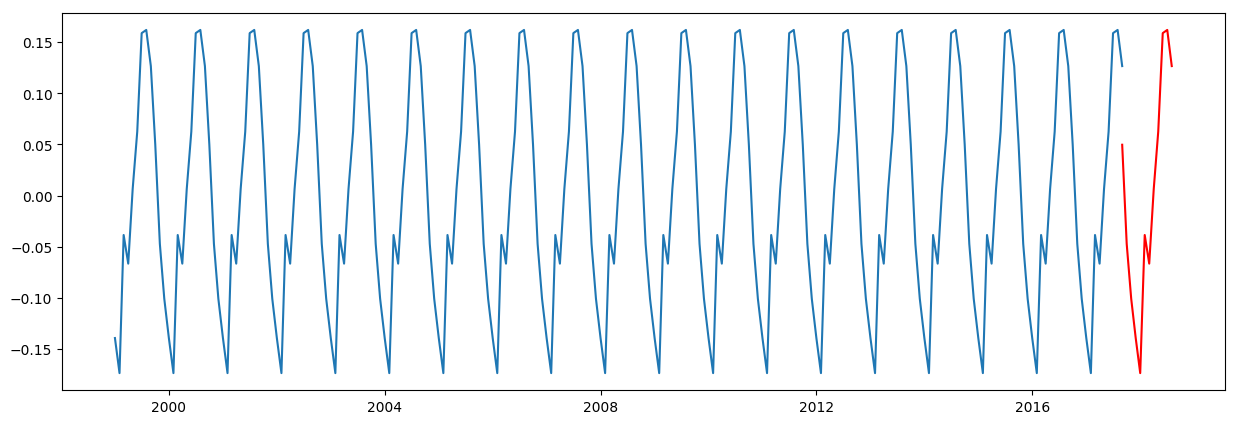

In [89]:

plt.plot(train.append(valid))
plt.plot(future_seasons, color='red')
plt.show()

# As we've made our residuals statinary, therefore we can predict them nice with Known ARIMA coeficients

In [90]:
prediction_index = generate_prediction_index (available_training_data=ts_log_decomposed_residuals, raw_data=raw_ts)

Providing [19] timestamps from [2017-03-01 00:00:00] to [2018-09-01 00:00:00]


## here we need to make more predictions to cover same time span due to lost of data in a process of ts decomposition

In [91]:
model = ARIMA(ts_log_decomposed_residuals, order=(2, 0, 1))
model_fit = model.fit() 

print (model_fit.aic)
model_fit.summary().tables[1]

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


-543.0963496837926


<class 'statsmodels.iolib.table.SimpleTable'>

In [93]:
fs = model_fit.fittedvalues
fs = pd.Series(index = ts_log_decomposed_residuals.index, data = fs)
predict_future_residuals = model_fit.forecast(len(prediction_index))[0]
predict_future_residuals = pd.Series(index = prediction_index, data = predict_future_residuals)

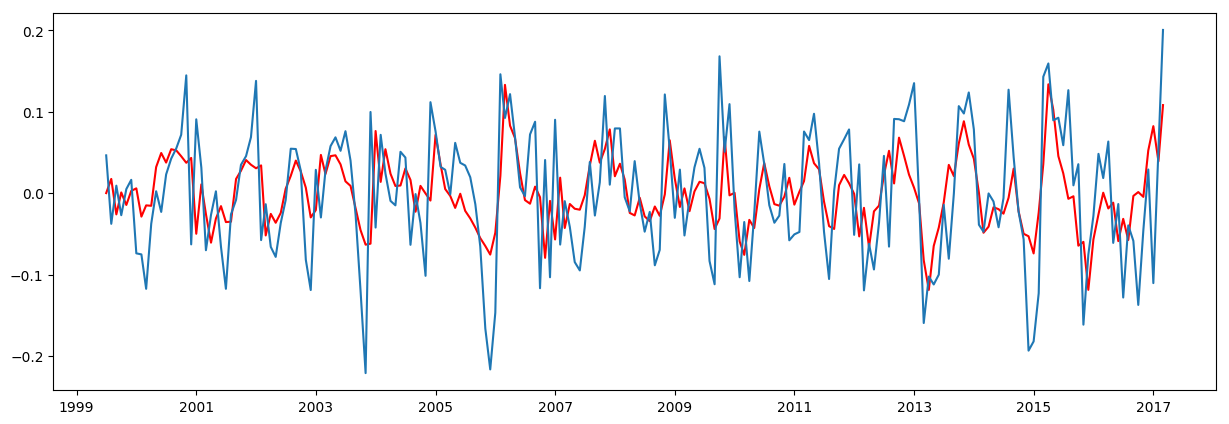

1.66835705692


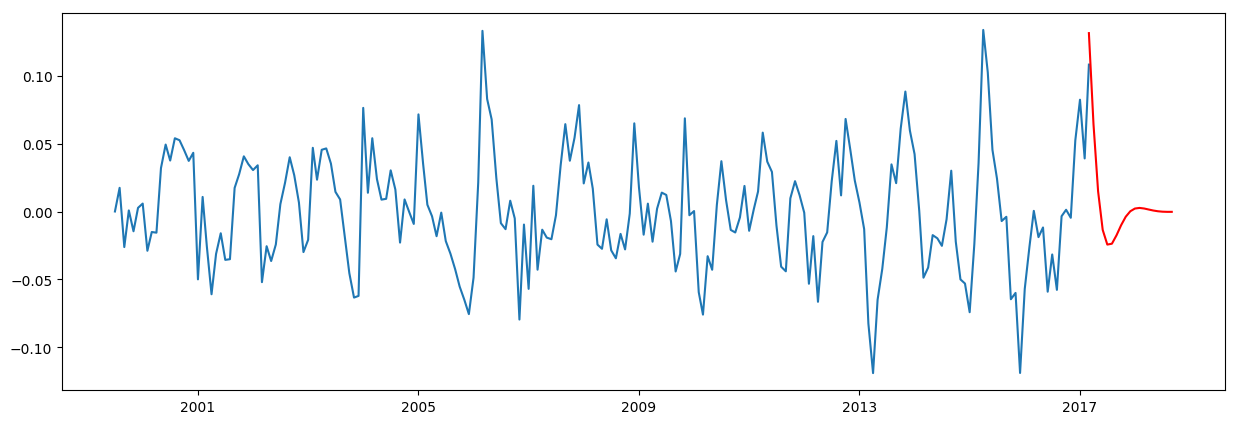

In [94]:
plt.plot(fs, color = 'red')
plt.plot(ts_log_decomposed_residuals)
plt.show()
print(my_MSE(fs, train))


plt.plot(fs)
plt.plot(predict_future_residuals, color = 'red')
plt.show()

In [97]:
# train, valid = split_lats_year(ts_log_decomposed_trend)

In [583]:
from sklearn.linear_model import LinearRegression as lr
import time
import numpy as np

In [584]:
Y_train, Y_test = split_lats_year(ts_log_decomposed_trend)

Data span from: [1999-07-01 00:00:00]  to: [2017-03-01 00:00:00]
Split_border [2016-04-01 00:00:00]  


In [585]:
Y_test.index

DatetimeIndex(['2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01'],
              dtype='datetime64[ns]', freq=None)

In [586]:
# X_train = DATA[0]['1999-07-01 00:00:00':'2016-03-01 00:00:00']
# X_test = DATA[0]['2016-04-01 00:00:00':'2017-03-01 00:00:00']

In [587]:
l_regr = lr(n_jobs = -1)
l_regr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [588]:
def make_self_dependant(ts, lags_list):
    T = np.array([time.mktime(t.timetuple()) for t in ts.index]) 
    T = T - (T).min()
    data_ = [T]
    data_.extend([Y_train.shift(lag) for lag in lags_list])
    Y_self = pd.DataFrame(data=data_)
    Y_self.dropna(inplace=True, axis=1)
    print(Y_self.T.shape)
    return Y_self.T

In [589]:
Y_self_train = make_self_dependant(Y_train, [3,5,7,9,17])
Y_self_test = make_self_dependant(Y_test, [3,5])
Y_self_train

(184, 6)
(7, 3)


0         1         2         3         4         5
17    44845200.0  4.692235  4.658252  4.633150  4.602037  4.614214
18    47523600.0  4.700538  4.678377  4.645073  4.614867  4.624992
19    50202000.0  4.704890  4.692235  4.658252  4.633150  4.620904
20    52621200.0  4.705247  4.700538  4.678377  4.645073  4.608653
21    55296000.0  4.698766  4.704890  4.692235  4.658252  4.596499
22    57888000.0  4.689837  4.705247  4.700538  4.678377  4.587856
23    60566400.0  4.682451  4.698766  4.704890  4.692235  4.585173
24    63158400.0  4.675402  4.689837  4.705247  4.700538  4.591593
25    65836800.0  4.666202  4.682451  4.698766  4.704890  4.602037
26    68515200.0  4.663627  4.675402  4.689837  4.705247  4.614867
27    71107200.0  4.667625  4.666202  4.682451  4.698766  4.633150
28    73789200.0  4.663677  4.663627  4.675402  4.689837  4.645073
29    76381200.0  4.661444  4.667625  4.666202  4.682451  4.658252
30    79059600.0  4.662375  4.663677  4.663627  4.675402  4.678377
31    81738000.0  4.658390  4.661444  4.667625  4.666202  4.692235
32    84157200.0  4.657371  4.662375  4.663677  4.663627  4.700538
33    86832000.0  4.663638  4.658390  4.661444  4.667625  4.704890
34    89424000.0  4.671958  4.657371  4.662375  4.663677  4.705247
35    92102400.0  4.679182  4.663638  4.658390  4.661444  4.698766
36    94694400.0  4.683822  4.671958  4.657371  4.662375  4.689837
37    97372800.0  4.682020  4.679182  4.663638  4.658390  4.682451
38   100051200.0  4.674375  4.683822  4.671958  4.657371  4.675402
39   102643200.0  4.668670  4.682020  4.679182  4.663638  4.666202
40   105325200.0  4.672552  4.674375  4.683822  4.671958  4.663627
41   107917200.0  4.682844  4.668670  4.682020  4.679182  4.667625
42   110595600.0  4.696890  4.672552  4.674375  4.683822  4.663677
43   113274000.0  4.715061  4.682844  4.668670  4.682020  4.661444
44   115693200.0  4.732431  4.696890  4.672552  4.674375  4.662375
45   118368000.0  4.748702  4.715061  4.682844  4.668670  4.658390
46   120960000.0  4.761537  4.732431  4.696890  4.672552  4.657371
..           ...       ...       ...       ...       ...       ...
171  449798400.0  5.047411  5.043895  5.047063  5.060057  5.064098
172  452480400.0  5.047502  5.046485  5.042615  5.054100  5.067713
173  455072400.0  5.055888  5.047411  5.043895  5.047063  5.078177
174  457750800.0  5.070421  5.047502  5.046485  5.042615  5.084816
175  460429200.0  5.083850  5.055888  5.047411  5.043895  5.081084
176  462848400.0  5.093786  5.070421  5.047502  5.046485  5.076602
177  465523200.0  5.097667  5.083850  5.055888  5.047411  5.072549
178  468115200.0  5.105974  5.093786  5.070421  5.047502  5.067389
179  470793600.0  5.114870  5.097667  5.083850  5.055888  5.060057
180  473385600.0  5.109396  5.105974  5.093786  5.070421  5.054100
181  476064000.0  5.095394  5.114870  5.097667  5.083850  5.047063
182  478742400.0  5.073421  5.109396  5.105974  5.093786  5.042615
183  481334400.0  5.047324  5.095394  5.114870  5.097667  5.043895
184  484016400.0  5.031171  5.073421  5.109396  5.105974  5.046485
185  486608400.0  5.033526  5.047324  5.095394  5.114870  5.047411
186  489286800.0  5.046195  5.031171  5.073421  5.109396  5.047502
187  491965200.0  5.055965  5.033526  5.047324  5.095394  5.055888
188  494384400.0  5.065991  5.046195  5.031171  5.073421  5.070421
189  497059200.0  5.076670  5.055965  5.033526  5.047324  5.083850
190  499651200.0  5.083860  5.065991  5.046195  5.031171  5.093786
191  502329600.0  5.087223  5.076670  5.055965  5.033526  5.097667
192  504921600.0  5.091000  5.083860  5.065991  5.046195  5.105974
193  507600000.0  5.088863  5.087223  5.076670  5.055965  5.114870
194  510278400.0  5.086217  5.091000  5.083860  5.065991  5.109396
195  512870400.0  5.091263  5.088863  5.087223  5.076670  5.095394
196  515552400.0  5.095393  5.086217  5.091000  5.083860  5.073421
197  518144400.0  5.085224  5.091263  5.088863  5.087223  5.047324
198  520822800.0  5.061747  5.095393  5.086217  5.091000  5.03

In [590]:
l_regr.fit(Y_self_train, Y_train.data[-len(Y_self_train):])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [591]:
Y_train_predict = l_regr.predict(Y_self_train)
# Y_test_predict = l_regr.predict(Y_self_test)
# Y_train_predict

In [592]:
Y_train_predict = pd.Series(index = Y_train.index[-len(Y_train_predict):], data = Y_train_predict)
Y_test_predict = pd.Series(index = Y_test.index[-len(Y_test_predict):], data = Y_test_predict)

In [593]:
Y_train.tail()

2015-11-01    5.035857
2015-12-01    5.009650
2016-01-01    4.982218
2016-02-01    4.952132
2016-03-01    4.928106
Name: Production, dtype: float64

In [594]:
Y_train_predict.tail()

2015-11-01    5.097681
2015-12-01    5.067833
2016-01-01    5.014408
2016-02-01    4.980604
2016-03-01    4.965615
dtype: float64

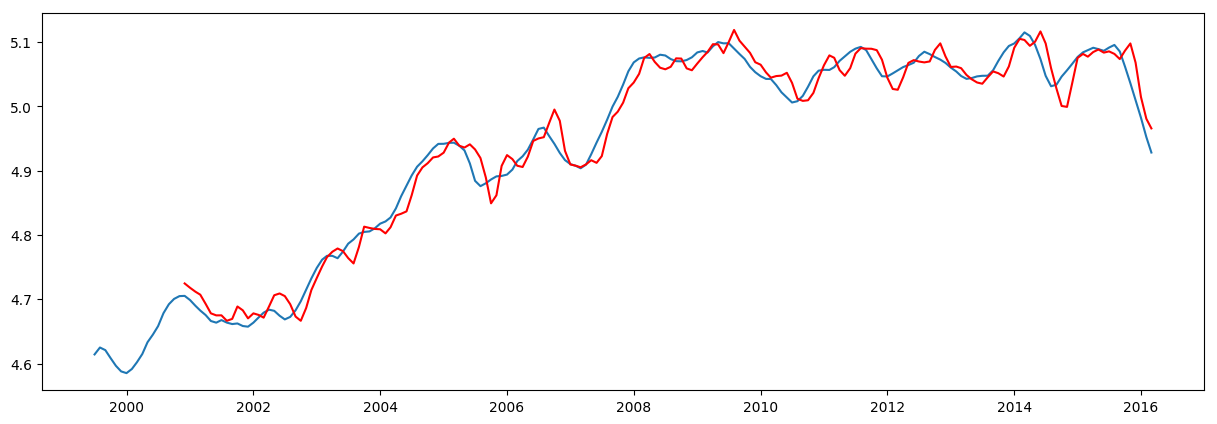

0.291287863258


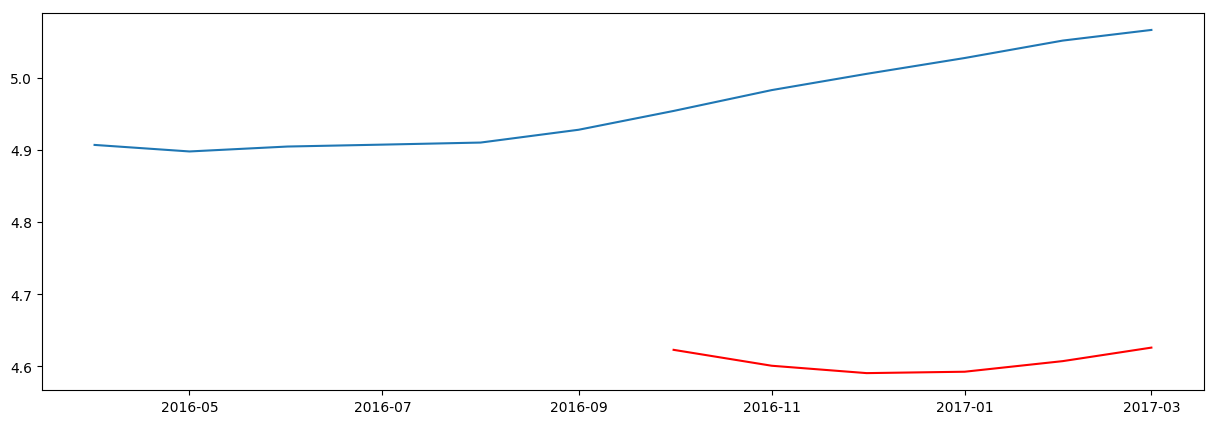

1.00382761113


In [595]:
plt.plot(Y_train)
plt.plot(Y_train_predict, color='red')
plt.show()
print (my_MSE(Y_train, Y_train_predict))


plt.plot(Y_test)
plt.plot(Y_test_predict, color='red')
plt.show()
print (my_MSE(Y_test, Y_test_predict))

In [638]:
lags = [-5]
Y_self = make_self_dependant(Y_all, lags)

(196, 2)


In [639]:
l_regr = lr(n_jobs = -1)
l_regr.fit(Y_self, Y_all[-len(Y_self):])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [640]:
print(Y_all.index)

DatetimeIndex(['1999-07-01', '1999-08-01', '1999-09-01', '1999-10-01',
               '1999-11-01', '1999-12-01', '2000-01-01', '2000-02-01',
               '2000-03-01', '2000-04-01',
               ...
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01'],
              dtype='datetime64[ns]', length=213, freq=None)


In [641]:
print(Y_all.index[-len(test):])
test.tail()

DatetimeIndex(['2000-10-01', '2000-11-01', '2000-12-01', '2001-01-01',
               '2001-02-01', '2001-03-01', '2001-04-01', '2001-05-01',
               '2001-06-01', '2001-07-01',
               ...
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01'],
              dtype='datetime64[ns]', length=198, freq=None)


2016-11-01    5.064737
2016-12-01    5.055206
2017-01-01    5.033722
2017-02-01    5.010071
2017-03-01    4.986164
dtype: float64

In [642]:
test = l_regr.predict(Y_self)
test = pd.Series(index = Y_all.index[-len(test):], data = test)

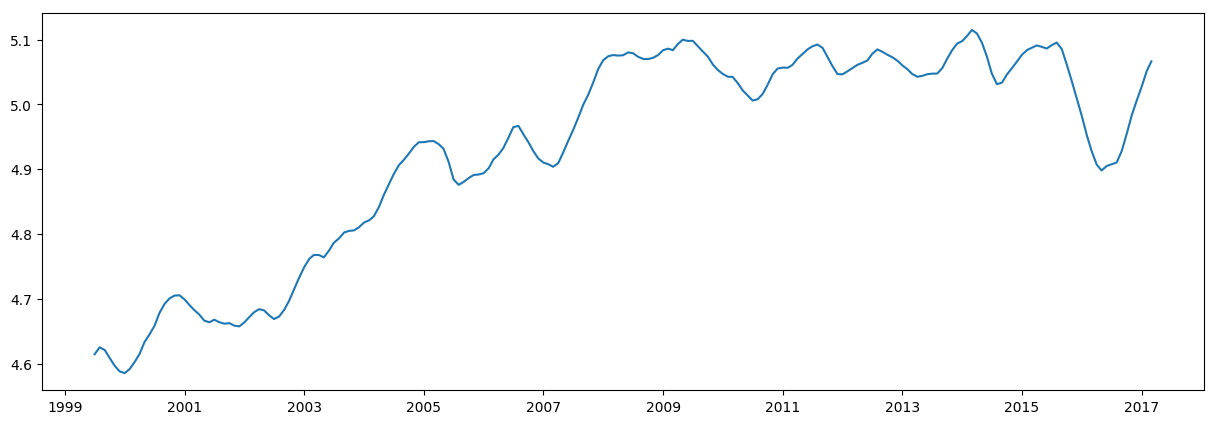

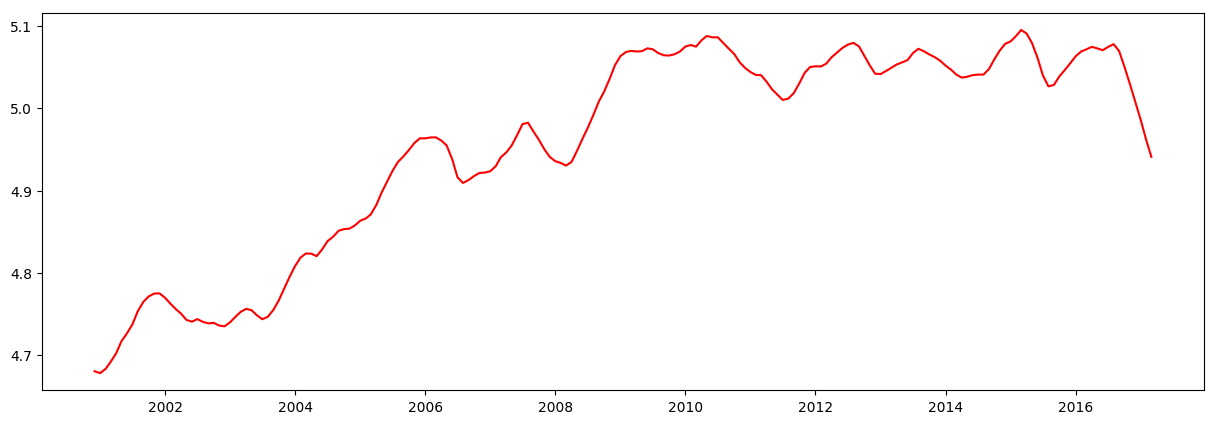

In [643]:
plt.plot(Y_all)
plt.show()
plt.plot(test, color = 'red')


plt.show()

In [385]:
my_MSE(Y_test_predict, Y_test)

0.0

In [ ]:
df_cp = df.dropna()

In [ ]:
df_cp.head()

In [ ]:
df_cp.shape

In [ ]:
lr = LinearRegression()
lr.fit(df_cp.loc[:, df_cp.columns != 'current'], df_cp["current"])

In [ ]:
def get_value_by_index(ts, i):
    if i >=0 and i < len(ts) and not np.isnan(ts.iloc[i]):
        return ts.iloc[i]
    return ts.mean()

In [ ]:
predictions = []
for i in range(len(ts_missed)):
    predict = lr.predict(np.array([
        get_value_by_index(ts_missed, i-12),
        get_value_by_index(ts_missed, i-1),
        get_value_by_index(ts_missed, i+1),
        get_value_by_index(ts_missed, i+12),
    ]).reshape(-1, 4))
    predictions.append(predict[0])
predictions = pd.Series(predictions, index=ts_missed.index)

In [ ]:
ts_filled = ts_missed.fillna(predictions)
ts_filled.plot()

In [ ]:
plt.plot(train)
plt.plot(valid, color='green')

In [ ]:
small_stat_test(train.diff(12)[12:])

In [ ]:
restored_forecast = np.exp(invert_diff_periods(combined_data_forecast, ts_log[:CYCLE]))
restored_train = np.exp(invert_diff_periods(combined_data, ts_log[:CYCLE])) 
plt.plot(restored_train[-len(valid):])
plt.plot(restored_forecast[-len(valid):], color='red')
plt.show()
plt.plot(restored_train)
plt.plot(restored_forecast[-len(valid):], color='red')
plt.show()
print("MSE : [{}]".format(my_MSE(restored_train[-len(valid):], restored_forecast[-len(valid):])) )

In [ ]:
restored_forecast = np.exp(invert_diff_periods(combined_data_forecast, ts_log[:CYCLE]))
restored_train = np.exp(invert_diff_periods(combined_data, ts_log[:CYCLE])) 
plt.plot(restored_train[-len(valid):])
plt.plot(restored_forecast[-len(valid):], color='red')
plt.show()
plt.plot(restored_train)
plt.plot(restored_forecast[-len(valid):], color='red')
plt.show()
print("MSE : [{}]".format(my_MSE(restored_train[-len(valid):], restored_forecast[-len(valid):])) )

In [ ]:
plt.plot(train.diff(12)[12:])

In [ ]:
model = ARIMA(train, order=(3, 0, 0))
model_fit = model.fit() 

print (model_fit.aic)
model_fit.summary().tables[1]

In [ ]:
plt.plot(train)
plt.plot(fs, color =  'red')

In [ ]:
fs = model_fit.fittedvalues
new = model_fit.forecast(12)[0]
new = pd.Series(index = valid.index, data = new)
new

In [ ]:
plt.plot(valid)
plt.plot(new, color =  'red')